In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

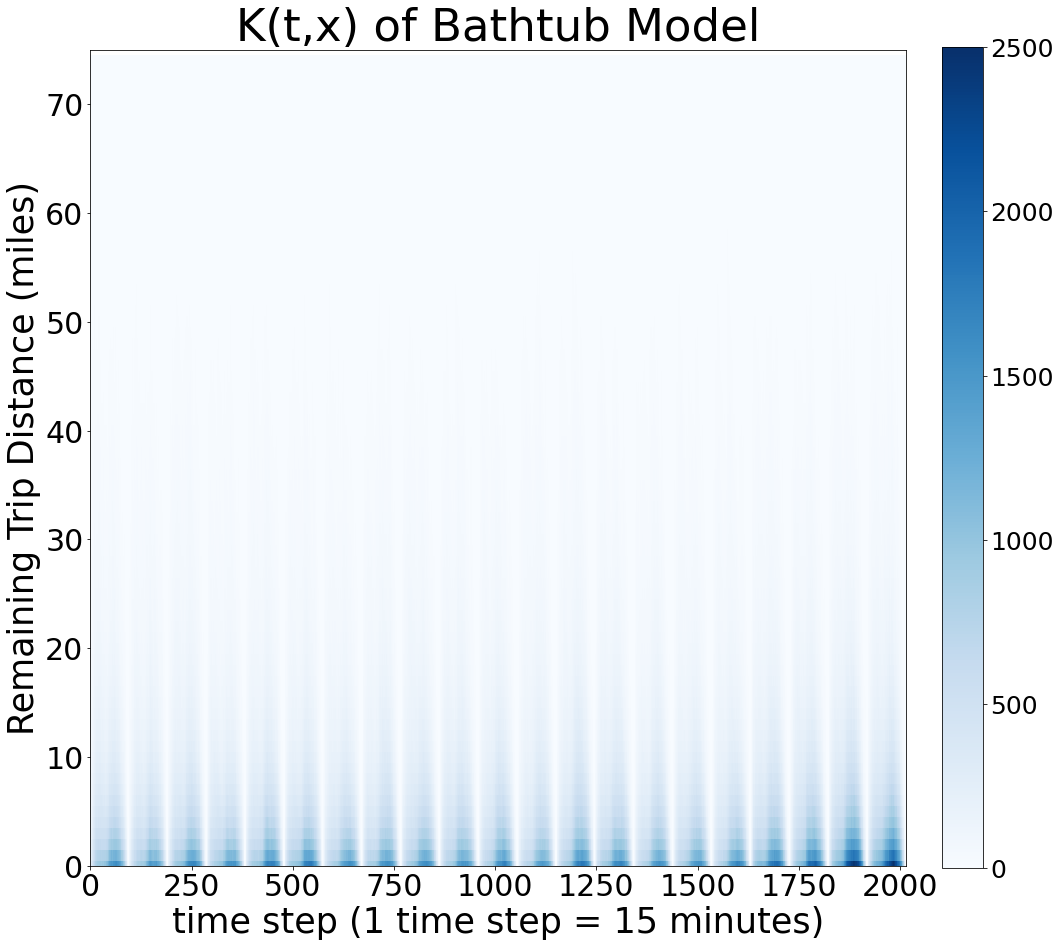

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 5 # unit: miles
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  30240
N_u =  6048
N_f =  12096


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(6048, 2)

In [12]:
X_u_test.shape

(24192, 2)

In [13]:
X_u_train

array([[0.        , 0.02630273],
       [0.54054054, 0.8382134 ],
       [0.94594595, 0.23722084],
       ...,
       [0.47297297, 0.98957816],
       [0.06756757, 0.87394541],
       [0.54054054, 0.92704715]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.066623604822916432 0.022498021902839505 0.11074918774299335 1.1453748192087903
0.0063078103720222009 0.0097880398154410429 0.0028275809286033588 0.7583621639455036
0.005975222595920095 0.0093943093599078865 0.0025561358319323036 0.7450586816083
0.0059487338218177019 0.0093663193277009373 0.0025311483159344656 0.7435972292188727
0.005895752658070747 0.0093604483902814586 0.0024310569258600358 0.7429394807619235
0.0057736542471849761 0.0094103371796444586 0.0021369713147254936 0.7444385217319305
0.005569776940484333 0.0095282850818660583 0.0016112687991026076 0.7490750882767412
0.0052916344240653 0.0095522992956770456 0.0010309695524535539 0.7507403002262829
0.0049377501953482249 0.0091140516448784854 0.00076144874581796421 0.7339783608824306
0.00473386999765096 0.0087360203790075152 0.00073171961629440486 0.7191384425175169
0.004683354193925517 0.0085814326392835774 0.000785275748567457 0.7125335200727664
0.0046490332391752875 0.0084647527400573373 0.0008333137382932382 0.707026560878

0.0032103737553624478 0.0055081473446746687 0.00091260016605022734 0.5742280649977589
0.0032097635747782784 0.0054894700328567475 0.00093005711669980919 0.5731827278954702
0.0032093905943157142 0.0054910837457155708 0.00092769744291585753 0.5732686335304573
0.0032088894778882445 0.005485371530559259 0.00093240742521723036 0.572956127735756
0.0032081882086860648 0.0054765485417278227 0.000939827875644307 0.5724463265663028
0.0032062838173471148 0.0054651858484438751 0.0009473817862503545 0.5717909711024047
0.0032046983978150484 0.005460304648808062 0.0009490921468220349 0.5714862319258598
0.0032021766886098685 0.0054503436808898383 0.00095400969632989849 0.5708560397453672
0.0031975885331835237 0.005451552485337568 0.00094362458102947931 0.5707572718738921
0.0031945657171806837 0.0054641083047724439 0.00092502312958892355 0.5713105205690087
0.00318919276226236 0.0054909169867842968 0.00088746853774042292 0.5727696420066296
0.0031870393664572109 0.0054803400864760817 0.000893738646438339

0.00316364349532057 0.0054262330693794145 0.00090105392126172518 0.568997771183208
0.0031625066840800247 0.0054272536325081274 0.00089775973565192168 0.5689061130889365
0.0031602111864541863 0.0054499687123574459 0.000870453660550927 0.5701732229317898
0.0031596784601627837 0.0054359060603491067 0.00088345085997646063 0.5695188869097204
0.003158619546055258 0.0054326533477304841 0.00088458574438003224 0.5693574162884999
0.0031569424786648086 0.0054275720156535551 0.00088631294167606242 0.5691476309523544
0.0031554307466202438 0.0054254082570302292 0.00088545323621025841 0.568957502210887
0.0031539890696239015 0.0054259723955229671 0.00088200574372483622 0.5690112955006577
0.003150018413224018 0.0054093384817157451 0.000890698344732291 0.5680619242735623
0.0031488091309202141 0.0054123716732065131 0.00088524658863391506 0.5682650872215029
0.0031480753117961563 0.0054130866592047161 0.00088306396438759659 0.568245871917653
0.003147608988323709 0.0054004539166659336 0.00089476405998148477

0.0030543171805273578 0.0052692625873138948 0.00083937177374082065 0.5604655293873376
0.0030540647098971892 0.00527320246294221 0.00083492695685216884 0.5606486662196835
0.0030539294220517182 0.0052739498700400244 0.000833908974063412 0.5606926431319612
0.0030537538307863449 0.0052739630988586431 0.00083354456271404677 0.5607129556047273
0.0030533181739530973 0.00527214468235151 0.00083449166555468453 0.5606801050329765
0.0030529602811617792 0.005273523507231751 0.00083239705509180711 0.5607755436364565
0.0030527022758882649 0.0052717860272193107 0.00083361852455721944 0.5606455861256117
0.0030525752267466727 0.0052701623198883989 0.00083498813360494693 0.5605606511491038
0.0030525301193261509 0.0052718760328237342 0.00083318420582856789 0.5606386550126036
0.0030524064511415218 0.0052730196683265472 0.00083179323395649615 0.5607000878268086
0.0030516851429003952 0.0052787693551187053 0.00082460093068208531 0.5609992207282616
0.0030507663582966626 0.00527693290351707 0.00082459981307625

0.0030252250953025257 0.0052036420374588638 0.00084680815314618736 0.5569764225765628
0.0030248815061853242 0.0051936796033738228 0.000856083408996826 0.5564216591306334
0.0030247338081271849 0.0051888909698269044 0.000860576646427465 0.5561681306235194
0.0030246228283476685 0.00518499360904014 0.00086425204765519688 0.5559675796575744
0.0030244009759847353 0.0051894958270036007 0.00085930612496587012 0.55619889210999
0.0030242924344733276 0.0051886674262566126 0.0008599174426900428 0.5561889369620793
0.0030241949209203378 0.0051904538606172895 0.00085793598122338639 0.5562916182847792
0.0030241322880124161 0.005188501930822465 0.00085976264520236693 0.5561719640514232
0.0030240907587696089 0.0051918844942573312 0.00085629702328188651 0.5563412342418327
0.003024057709811425 0.0051904924766053226 0.00085762294301752772 0.5562767151298152
0.0030240393399448297 0.0051900834330490782 0.00085799524684058114 0.5562519918449988
0.0030239999431936736 0.005190124349248231 0.00085787553713911652

0.0030096858629333856 0.0051305727171056153 0.00088879900876115566 0.5531932823078335
0.0030096605091867279 0.0051306811715744376 0.00088863984679901826 0.5531923383976881
0.0030096268833590292 0.0051316791685391237 0.00088757459817893458 0.5532413028611701
0.0030095911809812303 0.0051322132265674107 0.00088696913539504949 0.5532741873261714
0.003009566340788711 0.00513409052461967 0.00088504215695775262 0.553358177391567
0.00300949606176738 0.0051345269393437455 0.00088446518419101408 0.5533972536726717
0.003009346311479387 0.0051342775784245865 0.00088441504453418726 0.5534088978616934
0.00300909949547454 0.0051351250876568652 0.0008830739032922155 0.5534803126813171
0.0030086679146614182 0.0051355368813288662 0.00088179894799396983 0.5535190926118296
0.0030083471479438397 0.0051456391671055113 0.0008710551287821679 0.5540608028941177
0.0030079909252055952 0.0051443794637724355 0.00087160238663875451 0.553970008336243
0.0030075060906327908 0.0051324982376746049 0.000882513943590977 0

0.002998171274752 0.0051122529894860862 0.00088408956001791335 0.5521613322047795
0.0029981123288561891 0.0051157126962082348 0.00088051196150414339 0.5523661452788886
0.0029980378979248112 0.0051121756697968031 0.0008839001260528193 0.5521860071512602
0.0029979101832786361 0.0051113762019608672 0.000884444164596405 0.5521449885427647
0.0029977381943717307 0.0051173022779414015 0.00087817411080205992 0.5524453063821696
0.0029975868958197218 0.005112363437690037 0.00088281035394940661 0.5521967501956054
0.0029972258624264927 0.0051079945461409253 0.00088645717871205991 0.5519519334061164
0.00299676738098729 0.00511273719744392 0.00088079756453066039 0.5521594626237368
0.0029964156542519431 0.0051128225017738468 0.00088000880673003981 0.5521634821417397
0.0029961473401432883 0.0051244820434846348 0.00086781263680194216 0.5528224259235964
0.0029959233614249327 0.0051138113966836558 0.00087803532616620981 0.5522866656462455
0.0029956546955733692 0.0051111267629209952 0.00088018262822574342

0.0029861920419156423 0.0050864796637910114 0.00088590442004027315 0.5510781786143036
0.0029861459729154049 0.0050874387417371445 0.00088485320409366559 0.5511192613659397
0.002986081477264097 0.0050883583361049306 0.00088380461842326374 0.5511510802184933
0.0029860099744146262 0.0050907440744189115 0.000881275874410341 0.5512751551759701
0.0029859127087792994 0.0050869200682722836 0.00088490534928631489 0.5510631237968708
0.0029857414489426509 0.0050911557948728524 0.00088032710301244935 0.551297944384761
0.0029855889363740503 0.0050921519412758806 0.00087902593147221964 0.5513672336512873
0.0029854779105195892 0.0050910606910843769 0.00087989512995480192 0.5513341423474702
0.0029851798050448027 0.00508589443727359 0.00088446517281601494 0.5510758398743314
0.0029849340324337994 0.0050881019561821884 0.00088176610868541069 0.551237021174515
0.0029845877882799551 0.00508728104079767 0.00088189453576224049 0.5512265311309745
0.0029842692718555467 0.0050838407394000864 0.00088469780431100

0.0029378665603648894 0.0050244865727999922 0.00085124654792978656 0.5481386358152744
0.0029371060922750176 0.00503365399175526 0.00084055819279477454 0.5486307152984211
0.0029364993225080276 0.0050287763014401164 0.00084422234357593891 0.5483685908121788
0.0029356435587258606 0.0050297611179170691 0.000841525999534652 0.5483964326275628
0.002934859851458541 0.0050282353318156945 0.00084148437110138712 0.5482986891796376
0.0029340606063063971 0.0050314548717449179 0.00083666634086787626 0.5484538359244553
0.0029336738752600623 0.0050287933793556226 0.00083855437116450184 0.5482883249005869
0.0029332264439768476 0.0050326406696253149 0.00083381221832838051 0.5484824884024602
0.0029328278182576334 0.0050309437062675353 0.000834711930247731 0.5483902690144564
0.00293182619286328 0.0050325474162389219 0.00083110496948763767 0.54848644691894
0.0029311369513415381 0.0050247354284883756 0.00083753847419470052 0.5481066599141765
0.0029307577121396441 0.0050254451155070925 0.0008360703087721961

0.0029134007605780355 0.0049854375328080352 0.00084136398834803528 0.5463505981000439
0.0029133786640426589 0.0049841842231078117 0.000842573104977506 0.5462886824703855
0.0029133535634577796 0.0049827289650261463 0.00084397816188941323 0.5462132994291057
0.0029133363263717329 0.00498138288725188 0.00084528976549158585 0.5461402008922103
0.002913323328339293 0.0049809482097035252 0.00084569844697506068 0.5461180399476578
0.0029133058222594065 0.0049807504640851505 0.00084586118043366275 0.5461090013775258
0.0029132728431552945 0.0049810716027592957 0.00084547408355129319 0.5461321019397394
0.0029132494251160107 0.0049817546482475716 0.00084474420198444959 0.5461823015227057
0.0029132259532102548 0.0049815431026387393 0.00084490880378177032 0.5461743831364261
0.0029132005346617384 0.0049812369017152155 0.00084516416760826117 0.5461605450040955
0.0029131724233426078 0.004980246586605442 0.00084609826007977335 0.5461087275283467
0.0029131263382508959 0.0049782533438717125 0.00084799933263

0.0029063098980669959 0.0049679641285063757 0.0008446556676276161 0.5454757858502813
0.0029062384338986295 0.0049678806652962678 0.00084459620250099121 0.5454601715331981
0.0029061789167418536 0.004966478390186096 0.000845879443297611 0.5453585138423047
0.0029060596563721484 0.0049662650753109832 0.00084585423743331351 0.5453342735064671
0.002906019247341826 0.004966637486668069 0.00084540100801558252 0.5453483440156977
0.0029059906937109843 0.0049670277634147227 0.00084495362400724622 0.5453637618837256
0.0029059753068050977 0.0049670757735818145 0.00084487484002838042 0.5453667313721055
0.0029059629527482546 0.0049675480924095483 0.00084437781308696082 0.5453997297054901
0.0029059526119847956 0.0049672123397928253 0.00084469288417676563 0.545378493964628
0.002905939848729955 0.0049673088149375351 0.00084457088252237484 0.5453832966458956
0.0029059191812919704 0.0049678455079642169 0.00084399285461972428 0.54540985153498
0.0029058929366425476 0.0049670379458416972 0.000844747927443397

0.0029008225567931467 0.0049394928257276011 0.00086215228785869232 0.543881116568265
0.0029007514735583653 0.0049380814667227936 0.00086342148039393672 0.5437777740375295
0.0029006197125912019 0.0049398148526390026 0.00086142457254340121 0.5438702371957422
0.0029005123948321913 0.0049418796765185024 0.0008591451131458801 0.5439929715060039
0.0029004362808812078 0.00494044960113552 0.00086042296062689531 0.543937583564257
0.0029003581524655281 0.0049441465385865052 0.00085656976634455081 0.5441058056699595
0.0029002355934557382 0.0049439391560170722 0.00085653203089440413 0.5440897951351296
0.0029001054633643031 0.0049452646670009289 0.00085494625972767717 0.5441613594511517
0.002900019210919709 0.0049451641349492507 0.00085487428689016737 0.5441498725378751
0.0028998131121239236 0.0049487902317507815 0.00085083599249706574 0.5443367899399228
0.0028997065004091925 0.0049560058522021017 0.000843407148616283 0.5447385019503541
0.0028996218293433672 0.0049552443841722662 0.0008439992745144

0.0028960193256658251 0.0049353798979359523 0.000856658753395698 0.5437866307775304
0.0028959950362746792 0.0049351192441076915 0.00085687082844166675 0.5437748878697561
0.0028959833785524567 0.0049354495347388814 0.00085651722236603238 0.5437892987112334
0.002895973467612565 0.0049364819117280146 0.00085546502349711563 0.5438443306618119
0.0028959726350326746 0.0049379711970321451 0.00085397407303320434 0.5439352269749953
0.0028959629945715278 0.0049371055444420407 0.00085482044470101468 0.543887968755266
0.002895958941888183 0.0049371719383839632 0.00085474594539240321 0.5438922635465131
0.0028959500536573754 0.0049376725546993235 0.000854227552615427 0.5439223700182191
0.0028959412664753825 0.0049383063217347048 0.00085357621121606036 0.5439596859094721
0.0028959331530584707 0.0049390293903425128 0.00085283691577442834 0.543999766346704
0.0028959210669555705 0.0049396333838418746 0.0008522087500692666 0.5440310485178624
0.0028959014142117111 0.0049402632496026834 0.00085153957882073

0.0028920458978368823 0.0049237805047644845 0.00086031129090927963 0.5431465184698492
0.0028920227261007214 0.0049218524742953608 0.000862192977906082 0.543047518912196
0.0028920063020994261 0.0049212767042530435 0.00086273589994580906 0.543016219275028
0.0028919834840134837 0.0049214091656295395 0.00086255780239742792 0.5430231776561322
0.0028919661948608238 0.0049216332316931464 0.0008622991580285016 0.5430327602713909
0.0028919567648207608 0.004922344541002063 0.00086156898863945866 0.5430702980622862
0.0028919454256186648 0.0049222430197562849 0.00086164783148104493 0.5430590538550681
0.0028919257281109605 0.0049212074193470531 0.00086264403687486794 0.5429983011981272
0.0028919171701516219 0.0049196242605634641 0.00086421007973978012 0.5429026576972141
0.0028919069359021415 0.0049195750204466589 0.00086423885135762429 0.5428972047641881
0.0028918923382814836 0.0049196942056749541 0.00086409047088801334 0.5429174820112815
0.0028918787964733622 0.0049194538318435878 0.00086430376110

0.0028857028510304895 0.004916561785821001 0.0008548439162399783 0.5427830077918522
0.0028856160278697895 0.0049179766448741707 0.00085325541086540846 0.5428571341386622
0.0028855329437836191 0.004916121138773882 0.00085494474879335626 0.5427449212536349
0.0028854674142079211 0.0049161719026156016 0.00085476292580024063 0.5427456291362003
0.0028854194224594218 0.004916140432792271 0.00085469841212657287 0.542724316213164
0.0028853353738930243 0.0049167856752578981 0.00085388507252815023 0.5427743837563649
0.0028852978837293395 0.0049167229064351094 0.00085387286102356949 0.5427832159269013
0.0028852324922558452 0.0049157363809615405 0.00085472860355015 0.5427343337002004
0.0028851710265836781 0.0049156326691085122 0.00085470938405884424 0.5427273593387433
0.0028850977765417425 0.0049145433480991835 0.00085565220498430138 0.5426808143863148
0.0028850122631428328 0.0049132244313149038 0.00085680009497076173 0.5426176874984237
0.0028848993765842948 0.0049116423259431335 0.0008581564272254

0.0028686764042641861 0.00488666525242111 0.00085068755610726216 0.5412190795640744
0.00286841159454414 0.0048850533120977481 0.00085176987699053168 0.5411508384785031
0.0028683662830097279 0.0048883705363233811 0.00084836202969607467 0.5413327645625514
0.0028682035701084684 0.0048869147778787016 0.00084949236233823535 0.5412671321903547
0.0028681079112474472 0.004886134362964859 0.00085008145953003559 0.541219220285509
0.0028679529246091835 0.0048873537334155111 0.00084855211580285594 0.5412831338420484
0.0028678351082607832 0.0048876249279244987 0.000848045288597068 0.5413020092938058
0.0028677278548822913 0.0048891992105290615 0.0008462564992355215 0.5413892910184409
0.0028676294723861189 0.0048885466809291539 0.00084671226384308421 0.5413574963045906
0.0028674835609995659 0.0048881854987262562 0.00084678162327287592 0.5413283554894355
0.002867296637387723 0.0048861393613507369 0.00084845391342470869 0.5412246403613624
0.0028670090192470209 0.0048870915708710255 0.000846926467623016

0.0028548708733704409 0.0048839991308074638 0.00082574261593341839 0.5411159441503715
0.002854563483157622 0.0048819946360510857 0.00082713233026415821 0.5410037320892345
0.0028541485693196868 0.0048751118477345593 0.00083318529090481387 0.54064547913282
0.002853863070976295 0.0048742846635283386 0.00083344147842425147 0.540605379797973
0.0028535957024063974 0.0048701817257461892 0.00083700967906660568 0.540377904373017
0.002853410100625362 0.00487218805573423 0.00083463214551649347 0.540478204889904
0.002853222174024163 0.0048740696087081767 0.0008323747393401492 0.5405787626243804
0.0028530354055845849 0.0048764831392551691 0.00082958767191400058 0.5407035380577435
0.0028528361092639083 0.0048782121987698459 0.00082746001975797078 0.5407634242948572
0.0028526980573091091 0.0048801628917516139 0.00082523322286660449 0.5408855217998644
0.0028525075929655445 0.0048779329112541023 0.0008270822746769867 0.5407467423753933
0.0028522647316328708 0.0048771846705543079 0.00082734479271143408 

0.0028408512995419678 0.0048609651828542483 0.00082073741622968731 0.5400260485287178
0.0028407186435061948 0.0048593534849964409 0.00082208380201594859 0.5399209840911141
0.0028406156546958877 0.0048597200955065364 0.000821511213885239 0.5399312216936663
0.0028405617569936805 0.0048602749881782956 0.00082084852580906577 0.5399680128370231
0.0028404995167430071 0.0048615169449956449 0.00081948208849036972 0.5400369014588897
0.0028404300042427942 0.0048597167613308144 0.00082114324715477406 0.5399495821721905
0.0028403261001477323 0.0048597162361120752 0.00082093596418338934 0.539959253382367
0.0028401351070720662 0.0048617368200543111 0.00081853339408982119 0.5400847164169076
0.0028400021828626854 0.0048616328122516646 0.00081837155347370581 0.5400697481765855
0.0028397805696629354 0.0048611282434761318 0.00081843289584973924 0.5400233107640584
0.0028396641680342488 0.0048589190942806828 0.00082040924178781473 0.5398918531007125
0.0028395393928026852 0.0048576552426887083 0.00082142354

0.0028338517220078429 0.0048347604505747906 0.0008329429934408949 0.5387029227476219
0.0028338202394155186 0.0048307644966342992 0.00083687598219673773 0.5384795431013006
0.0028337624270290875 0.0048315988643093917 0.00083592598974878375 0.538530418518502
0.0028337106085330479 0.0048315496921067158 0.00083587152495937964 0.5385275593280532
0.0028336858967335848 0.0048315993463612867 0.00083577244710588317 0.538527795250523
0.0028336317104729653 0.0048290749110684482 0.00083818850987748249 0.5384098951502676
0.0028335824255236474 0.0048289919369130319 0.00083817291413426274 0.5383826845817449
0.0028335304771658068 0.0048289551304320118 0.00083810582389960155 0.5383769254345248
0.0028334602981677725 0.0048276849293169 0.000839235667018645 0.5383031623613621
0.0028334185574041275 0.0048286596297203435 0.00083817748508791153 0.5383547041990625
0.0028333705781963337 0.0048306545098139291 0.000836086646578738 0.5384812973508413
0.0028333236074585531 0.0048305582360711405 0.000836088978845965

0.0028252517490966636 0.004799095984998651 0.00085140751319467641 0.5368939047213799
0.0028250207654315312 0.004801998461531262 0.00084804306933180043 0.5370669444029836
0.0028249094429712092 0.0048022011771902094 0.0008476177087522091 0.5370926391868297
0.0028247456668163075 0.0048037356563371 0.00084575567729551471 0.5371989194968038
0.0028246576962175176 0.0048021082302858861 0.000847207162149149 0.5371240521267623
0.0028245509599563994 0.0048002798128226254 0.00084882210709017359 0.5370178299659505
0.0028244645826291017 0.0048006718477096215 0.000848257317548582 0.5370407192850402
0.0028243963049333445 0.0047989936642914332 0.00084979894557525614 0.5369647474623284
0.0028243322004466451 0.00479946973766302 0.00084919466323027 0.5369831489062562
0.0028242815990868124 0.0047991028545738244 0.00084946034359980032 0.5369471414765856
0.0028242433437967534 0.0047983708760976672 0.00085011581149583963 0.5369065100382576
0.0028242192557010508 0.0047988226753620548 0.00084961583604004694 0.

0.002816406564992345 0.0048045763711900853 0.0008282367587946044 0.536934171723559
0.0028163555066578524 0.00480487185318616 0.00082783916012954409 0.5369420610857931
0.0028163234704947316 0.0048048514582473443 0.00082779548274211872 0.5369432123992024
0.002816261973518207 0.0048057568167894846 0.00082676713024692941 0.5369913525107828
0.0028161829190318332 0.0048053522324742965 0.00082701360558936992 0.5369679217207508
0.0028159938443728847 0.0048085782184243567 0.00082340947032141256 0.5371330859689613
0.0028157895498208104 0.0048092510235367624 0.00082232807610485787 0.5371894577692821
0.0028156146601343284 0.004810593201823277 0.00082063611844537939 0.5372459071473242
0.0028154292017447151 0.0048097673837588359 0.000821091019730594 0.5372188644536227
0.0028153449362068113 0.0048084197585726981 0.00082227011384092481 0.5371774005120292
0.0028152565900310916 0.0048091841021755807 0.00082132907788660264 0.5372035945268755
0.0028151676034242857 0.0048081191914177823 0.00082221601543078

0.0028093887702104821 0.004793189623999012 0.00082558791642195245 0.5363479580762233
0.0028089695184023212 0.0047945383302443892 0.00082340070656025308 0.5364285118134657
0.0028084776438765989 0.0047928955757542231 0.00082405971199897468 0.5363163318672161
0.0028082204839750655 0.0047918220360198081 0.00082461893193032322 0.5362822622451359
0.002808039179240206 0.00479221108474576 0.000823867273734652 0.5362729851067303
0.0028078300948164063 0.0047915698276686115 0.00082409036196420078 0.5362215387515826
0.0028076681203635045 0.0047927790602796359 0.00082255718044737321 0.5362903510337137
0.0028075686270986624 0.0047932434319203606 0.00082189382227696426 0.5363131469272157
0.002807351302539042 0.0047925677402997115 0.00082213486477837236 0.5362610297359383
0.0028072598417561274 0.0047933007228377822 0.00082121896067447278 0.5363034558644673
0.0028071427450019229 0.0047938635949950816 0.00082042189500876426 0.5363084469775996
0.0028070038158701334 0.0047933897165251937 0.000820617915215

0.0027963949905162166 0.0047743873911420655 0.00081840258989036721 0.5350715052148589
0.0027962814209089412 0.0047754960797721244 0.00081706676204575839 0.5351332153856375
0.0027960484792692161 0.0047721854392144374 0.00081991151932399482 0.5349667191164634
0.002795821728382818 0.0047688052248414572 0.000822838231924179 0.53477129142668
0.002795695445460991 0.0047679069768093206 0.00082348391411266118 0.5347150264021118
0.0027955009807799388 0.0047690678866598619 0.00082193407490001584 0.5347953128285846
0.0027953465475095722 0.0047676420899296886 0.00082305100508945587 0.5347133936857679
0.002795217462662601 0.0047675063487050721 0.00082292857662012936 0.5347189029241838
0.0027951219439753877 0.0047687816908934507 0.00082146219705732458 0.5347893258108146
0.0027950347695599497 0.0047699570021572752 0.0008201125369626239 0.534834991650186
0.0027949829553483457 0.00477282323339551 0.00081714267730118126 0.5350114007946273
0.0027948982602086594 0.0047711412455027731 0.0008186552749145458

0.0027840673611537856 0.0047535617061597807 0.00081457301614779032 0.5340112408871089
0.0027839688232054161 0.0047536649893900095 0.00081427265702082262 0.534021333578937
0.0027838564687120157 0.0047525061300719065 0.00081520680735212457 0.5339596795489097
0.0027836244440221443 0.0047527465974210063 0.00081450229062328232 0.533965082245263
0.0027834880979384084 0.0047534619861621819 0.00081351420971463519 0.5339985559955013
0.0027833954504490267 0.0047551726795225131 0.00081161822137554014 0.5340667223706653
0.0027832193661325253 0.0047540316268077486 0.0008124071054573023 0.534001178922485
0.0027831232598166554 0.0047525586095758738 0.0008136879100574374 0.5339397894284992
0.0027830563342451089 0.0047537030291601584 0.00081240963933005932 0.5339973121477414
0.0027829811440692543 0.00475391821220734 0.00081204407593116863 0.5340178281806117
0.0027829054684199808 0.00475740526094266 0.00080840567589730145 0.53419930305752
0.0027828143510679111 0.004758961196306883 0.00080666750582893891

0.0027745065078164165 0.0047470521976246318 0.00080196081800820111 0.5338415084655989
0.0027744601081836819 0.0047483274543751843 0.00080059276199217989 0.5339115508330718
0.0027744039618416011 0.0047496365372679539 0.00079917138641524864 0.533980374305887
0.0027743322052389136 0.0047504427546228353 0.00079822165585499228 0.5340175312368522
0.0027741807558033156 0.0047499950260993084 0.0007983664855073225 0.5339956245968607
0.0027741194181935603 0.0047511344040013191 0.00079710443238580184 0.5340423623956476
0.002774030612506642 0.0047457309108834668 0.00080233031412981686 0.5337205058259125
0.0027737741193180651 0.0047421533152553381 0.00080539492338079193 0.5335417044834369
0.002773645359170053 0.0047433168969984209 0.00080397382134168556 0.5336069396636771
0.002773546664278136 0.0047434588654680912 0.00080363446308818033 0.533600991187629
0.0027734473127169284 0.0047442148491559271 0.00080267977627792989 0.5336609574951379
0.002773403071958034 0.0047442994086411725 0.000802506735274

0.0027682883185872918 0.0047519576808082234 0.00078461895636636008 0.5342156344174109
0.0027682545401213521 0.0047522152512772843 0.00078429382896541967 0.5342343272593266
0.0027681979511828508 0.0047518019450625724 0.00078459395730312933 0.5342182962214883
0.0027681549692393547 0.0047517730180999971 0.00078453692037871255 0.5342126678109277
0.0027680864255576931 0.00475084823944814 0.00078532461166724626 0.5341631270944981
0.0027679925410823256 0.0047493087563979771 0.00078667632576667388 0.5340664139925239
0.0027679360242550757 0.0047481292190382721 0.00078774282947187922 0.5339930846748838
0.0027678790639377423 0.0047480424741248774 0.00078771565375060728 0.5339710975130088
0.0027678054400051264 0.0047471538412155933 0.00078845703879465976 0.5339315513995836
0.0027677282791810456 0.0047457806291362073 0.00078967592922588351 0.5338741580395264
0.0027676110831930624 0.00474387968838511 0.00079134247800101551 0.5337895747712964
0.0027675880523800674 0.0047443862766369214 0.000790789828

0.0027478322676994659 0.0047202546796875 0.00077540985571143185 0.532372860601727
0.0027475786879352579 0.0047180162191594772 0.00077714115671103832 0.5322220631233806
0.00274735158824207 0.0047155411986117765 0.00077916197787236382 0.5320783336053652
0.0027472598832620548 0.0047120592110050895 0.00078246055551902034 0.5318904226842746
0.0027471494179830808 0.004713474900482518 0.00078082393548364361 0.5319852172612128
0.0027470749013940084 0.0047133192256932892 0.00078083057709472773 0.531979365590924
0.0027470037627494383 0.0047136885490106171 0.00078031897648825929 0.5320038901666078
0.0027469000322846468 0.004713257548360641 0.00078054251620865228 0.5319778079902664
0.002746771246206032 0.0047129219711680827 0.00078062052124398113 0.5319716087858997
0.0027466942605590939 0.0047106226455458115 0.00078276587557237658 0.5318435468846789
0.0027466492448252381 0.0047100819033977235 0.0007832165862527525 0.5317964691182804
0.0027465699308963322 0.0047119527274685942 0.0007811871343240705

0.0027364348086669327 0.0047217263962530042 0.0007511432210808611 0.5323623802223559
0.0027362355804067 0.0047247916887003735 0.00074767947211302707 0.5324926635360492
0.0027359238653016653 0.0047245504996772086 0.00074729723092612237 0.5324962789858358
0.00273549218771554 0.0047199218233319488 0.00075106255209913186 0.5322422892156272
0.0027352940267652104 0.0047150708478534724 0.00075551720567694828 0.5319692370022046
0.0027349898282965942 0.0047122124591846611 0.00075776719740852747 0.5318291776572998
0.0027349002202515637 0.0047113867983371652 0.000758413642165962 0.5317894769059289
0.0027348259606665023 0.0047126507436072414 0.00075700117772576324 0.5318719081160472
0.0027347418889861995 0.0047158115816534757 0.0007536721963189234 0.5320441204093692
0.0027347118487185923 0.0047174806374926945 0.00075194305994449 0.5321290909213595
0.0027346294014677195 0.0047175580396515678 0.00075170076328387122 0.5321419448138719
0.0027345844024911016 0.0047173963511797463 0.000751772453802457 0

0.0026488339315653411 0.0046608291380588725 0.00063683872507181013 0.5301251629803178
0.0026476158884241358 0.0046621858467051861 0.00063304593014308565 0.5302214660044369
0.0026467929213878981 0.0046615600810383934 0.00063202576173740257 0.5301996445086079
0.0026460956697895287 0.0046646635222063809 0.00062752781737267671 0.5303135521502749
0.0026449372847510478 0.0046671276590251687 0.000622746910476927 0.5304274004673296
0.0026441586126280591 0.0046708259940831691 0.00061749123117294945 0.5306164486116335
0.00264332519129138 0.00467334360583441 0.00061330677674835009 0.5307574266390476
0.0026424316861684925 0.0046700153971487822 0.00061484797518820251 0.5305508411001852
0.0026410309395331322 0.0046672379598827942 0.00061482391918347057 0.5304135609085842
0.0026398746254192515 0.0046650180780887576 0.00061473117274974537 0.5303158004228482
0.0026392452659346785 0.0046644703557150273 0.00061402017615432936 0.5302928672093334
0.0026381381224492256 0.0046657609817045489 0.00061051526319

0.002603640117120963 0.0046737937784249476 0.00053348645581697846 0.5304658079828423
0.0026035568646679405 0.0046744457460532185 0.00053266798328266212 0.530488400858479
0.0026035174162199245 0.0046746531344394127 0.0005323816980004367 0.5305024655864542
0.0026034729910384994 0.0046743017232151593 0.00053264425886183949 0.5304852480152418
0.0026034628422389994 0.0046739011391432562 0.00053302454533474242 0.5304770007399005
0.0026034407520761239 0.0046734815084793777 0.00053339999567286994 0.5304470578755821
0.002603405856307387 0.0046727122497805841 0.00053409946283419025 0.5304035458675805
0.0026033549249892722 0.0046715819062121211 0.000535127943766423 0.5303383051481391
0.00260326844443451 0.0046702492027875814 0.00053628768608143871 0.5302683199221129
0.002603151328041405 0.00466983747828626 0.00053646517779655013 0.5302426777001656
0.0026030367831251155 0.0046707577221069075 0.00053531584414332324 0.5302856182714709
0.0026029946418875487 0.0046715547378780031 0.0005344345458970943

0.0025961966010553269 0.0046628159281704882 0.00052957727394016541 0.5296453712213062
0.0025961420834975492 0.0046634605976616913 0.00052882356933340723 0.5296791508908146
0.0025960952142183584 0.0046639452567001369 0.0005282451717365796 0.5297286331101022
0.0025960712213829043 0.0046641226414150666 0.0005280198013507425 0.5297300363010011
0.002596033961722719 0.00466432140896369 0.00052774651448174762 0.5297446247939154
0.0025959667214756231 0.0046650348451163955 0.00052689859783485089 0.5297901910666811
0.0025959306931296641 0.0046668223542967345 0.00052503903196259364 0.5298825584322627
0.00259584587185503 0.0046677453762387763 0.00052394636747128361 0.5299381757128776
0.0025957729040206978 0.0046682969239166044 0.0005232488841247912 0.529965222870074
0.0025956722126277742 0.0046682502084840214 0.00052309421677152737 0.5299574767053443
0.0025954024676455491 0.0046661564533347589 0.00052464848195633927 0.5298178699939267
0.0025953272107395388 0.0046659468273861637 0.00052470759409291

0.0025816466731276031 0.0046907454536873165 0.00047254789256789007 0.5310044661470696
0.0025814838024120542 0.0046898283067404734 0.00047313929808363511 0.5309708916842591
0.0025812825806443367 0.0046888678905169538 0.00047369727077171964 0.5309202927008174
0.0025810484382879466 0.0046875176508354242 0.00047457922574046862 0.5308383506517356
0.0025807789684970713 0.0046870092410517244 0.00047454869594241783 0.530801754556458
0.0025804891888121647 0.00469092856583797 0.00047004981178635938 0.5310315493248289
0.0025803573804384292 0.0046916333730732439 0.00046908138780361473 0.5310804717889348
0.002580059407438997 0.004690144301727618 0.00046997451315037577 0.5310000200782304
0.00257985231704105 0.0046904606274702507 0.00046924400661184986 0.5310282080195637
0.0025795850072782415 0.004687764450233071 0.00047140556432341183 0.5308921394267802
0.0025792801161157179 0.00468835121022872 0.00047020902200271543 0.5309539070432893
0.0025791107994187078 0.0046893933520983 0.00046882824673911543 

0.0025732967445844042 0.0046909861750579415 0.00045560731411086651 0.5311087221491558
0.002573230602778268 0.0046917381126232206 0.00045472309293331548 0.531105163062199
0.0025730536081324919 0.004692152213661302 0.00045395500260368195 0.5311621792531557
0.0025730083268827061 0.0046919547104283671 0.000454061943337045 0.5311551735458858
0.0025729267838791809 0.0046912115276951027 0.00045464204006325941 0.5311189647295085
0.0025728117900437777 0.0046897261380713018 0.00045589744201625403 0.5310456946645135
0.0025727848483670952 0.0046907390046391721 0.0004548306920950187 0.5311147752716
0.002572703777731613 0.0046897836595786472 0.00045562389588457909 0.531061513837022
0.0025726694892103047 0.0046892196580274595 0.00045611932039315016 0.5310374876735604
0.0025726052752386482 0.0046879504493367542 0.00045726010114054193 0.5309818142230605
0.0025725611717608296 0.004686087270946407 0.00045903507257525266 0.5309016833222803
0.0025725215211977325 0.0046846843281926273 0.00046035871420283729

0.0025682953974308712 0.00467310006467729 0.00046349073018445218 0.530059361853992
0.0025682625528157437 0.0046727082210874958 0.00046381688454399125 0.5300438055190158
0.0025682381733161995 0.0046728516420918714 0.00046362470454052796 0.5300468335182941
0.002568211864685207 0.0046730090584765115 0.00046341467089390216 0.5300629559776019
0.0025681810656875189 0.004673102207989277 0.00046325992338576124 0.5300767500687839
0.0025681675531120775 0.0046722604961865945 0.00046407461003756081 0.5300311375172351
0.00256813530630438 0.0046729246394044939 0.00046334597320426554 0.5300712020972673
0.002568134402308559 0.0046728757257901415 0.00046339307882697683 0.5300674536177756
0.0025681138535609215 0.0046731638167697058 0.00046306389035213717 0.5300864425427549
0.002568091082840319 0.0046733497375974088 0.000462832428083229 0.530093840457043
0.0025680712404166947 0.0046734539226197785 0.00046268855821361091 0.5300981323760399
0.0025680593020875669 0.0046734402214132472 0.00046267838276188659

0.0025632886161697939 0.0046690964613794461 0.000457480770960142 0.529710020217719
0.0025632559022201492 0.0046691842135685455 0.00045732759087175337 0.5297073390605853
0.0025631951142242797 0.0046679744932092027 0.00045841573523935664 0.5296435900432493
0.0025631616614121191 0.0046677188710857274 0.000458604451738511 0.5296119113816952
0.002563135400216143 0.0046673146389957891 0.00045895616143649693 0.5295722704068738
0.002563105576196289 0.0046663911169262844 0.00045982003546629358 0.5295201650928241
0.0025630927510853141 0.0046667023993344024 0.00045948310283622571 0.5295350770804943
0.0025630836660008142 0.0046671529738879338 0.00045901435811369505 0.5295601621881806
0.0025630282083040916 0.0046664567963811115 0.00045959962022707195 0.5295057440199062
0.0025629865491558347 0.0046654954029930066 0.0004604776953186632 0.5294435583112873
0.0025628998782312846 0.0046636063648068452 0.00046219339165572403 0.5293260728854938
0.0025628568985551431 0.0046635423712548668 0.0004621714258554

0.0025525282361325606 0.00469344593658393 0.00041161053568119089 0.5309697893767544
0.0025524624209093288 0.0046949396217639532 0.000409985220054704 0.53105699253192
0.0025523955791946504 0.0046960883422546822 0.00040870281613461848 0.5311354956059948
0.002552326310659896 0.00469652622487195 0.00040812639644784165 0.5311783439095028
0.0025522640865356097 0.0046967928583437641 0.00040773531472745493 0.5312028015801359
0.0025521638616988543 0.0046976448348418874 0.00040668288855582078 0.5312638546612986
0.0025520794690548632 0.00469758345514456 0.00040657548296516623 0.5312815420030406
0.002552031123655909 0.0046983408578168189 0.00040572138949499919 0.5313388912127913
0.0025520115799627786 0.00469809616828012 0.00040592699164543767 0.5313279640593135
0.0025519717435404658 0.0046974184893973066 0.00040652499768362491 0.5313128182688589
0.0025519266705467752 0.0046969977882448336 0.00040685555284871653 0.5313060652969016
0.0025518873333600462 0.0046979442487405758 0.0004058304179795167 0.

0.0025461365021866656 0.0047071993481611141 0.00038507365621221688 0.5318353343543948
0.0025460364925219943 0.0047077339517260031 0.00038433903331798594 0.5318686830334977
0.0025459435926399052 0.0047082930275472784 0.00038359415773253175 0.5318904613864718
0.0025457835841758672 0.00470628739121311 0.0003852797771386247 0.531761880482326
0.0025457098321317166 0.00470763816596938 0.000383781498294053 0.5318745966619606
0.0025455086868152606 0.0047064774788275112 0.00038453989480301037 0.5318147758190581
0.0025452121357717127 0.0047022111659708026 0.00038821310557262317 0.5315645171634547
0.0025449897429008521 0.00470075061376927 0.00038922887203243463 0.5314869799652127
0.0025447233395918356 0.004695604717609967 0.00039384196157370383 0.5312308290260197
0.0025446283743531051 0.0046956495927578494 0.00039360715594836124 0.5312379699951838
0.0025445933828697155 0.0046971831174856321 0.00039200364825379915 0.5313193466128984
0.0025444049230842264 0.0046969111548521777 0.0003918986913162749

0.0025358853722544138 0.0046814433236725319 0.000390327420836296 0.5303099428336077
0.0025358720422623093 0.00468165023326317 0.00039009385126144891 0.5303245841509846
0.002535864235354764 0.0046817160577661086 0.00039001241294341955 0.5303234861078128
0.0025358559448806421 0.0046816063248920044 0.00039010556486928 0.5303171404008589
0.0025358369251009985 0.0046826614155105325 0.00038901243469146408 0.530368594831154
0.0025358222975855821 0.0046821517323739435 0.00038949286279722062 0.5303372433525474
0.002535808355022593 0.0046818519121967477 0.00038976479784843832 0.5303130814398439
0.0025358075376041159 0.0046819766542138645 0.00038963842099436744 0.530318814499128
0.0025358048650168251 0.0046821775114339065 0.00038943221859974328 0.5303291403389357
0.0025358005327147178 0.0046827883676953674 0.00038881269773406837 0.5303605225645146
0.0025357944065075373 0.0046831995468594578 0.00038838926615561686 0.5303825128173786
0.0025357802752342205 0.0046836916750698553 0.0003878688753985855

0.002534288920987914 0.004674700529104737 0.00039387731287109123 0.5298232944277801
0.0025342840580088503 0.0046747004860286942 0.00039386762998900622 0.5298198939763066
0.0025342787764397134 0.0046747180445953643 0.00039383950828406278 0.5298174725106832
0.0025342756257399931 0.0046748970345251092 0.000393654216954877 0.529824334906859
0.0025342739538652074 0.0046746775953666444 0.0003938703123637708 0.5298118447846187
0.0025342736692445357 0.0046746021456849605 0.00039394519280411093 0.5298074816259639
0.0025342703029106687 0.004674432956239186 0.00039410764958215167 0.5297952599729377
0.0025342666821348216 0.00467428724843783 0.00039424611583181306 0.5297892560742211
0.0025342579167684631 0.0046744556779596018 0.00039406015557732457 0.529803199843901
0.0025342487849456395 0.0046747615750357277 0.00039373599485555166 0.5298242898479879
0.0025342437679567341 0.0046749756807223288 0.00039351185519113897 0.5298367385250476
0.0025342411662177271 0.0046752153384239685 0.000393266994011485

0.0025265216123685711 0.00465453112007393 0.000398512104663212 0.5284145018519337
0.002526481554882934 0.0046547505840672078 0.00039821252569866033 0.528435763954146
0.0025264501892590207 0.0046543820737585933 0.00039851830475944792 0.5284235890799243
0.0025264174138179638 0.0046548951358813279 0.00039793969175459933 0.5284508738066148
0.0025263899577974546 0.0046546435988071714 0.00039813631678773818 0.5284376437873983
0.0025263546090769744 0.0046554587301526713 0.0003972504880012775 0.5284791704365297
0.0025263251727523778 0.0046560065973499359 0.00039664374815481931 0.5285060582667455
0.0025263011303293796 0.0046557659565130017 0.00039683630414575716 0.5284924029027313
0.0025262822464641004 0.0046552663202489072 0.0003972981726792932 0.528461764733232
0.00252626262675876 0.0046549970313599469 0.00039752822215757317 0.528441635197956
0.0025262407537328885 0.0046546718348845963 0.00039780967258118107 0.5284199506774625
0.0025261993304213177 0.0046546760520993716 0.000397722608743264 0

0.0025227886190430471 0.0046601890128501666 0.00038538822523592753 0.5287253347055693
0.0025227674403429023 0.0046603743288426321 0.00038516055184317245 0.5287351067828429
0.0025227280157072143 0.0046599034098728518 0.00038555262154157667 0.5287065723491062
0.00252270136977292 0.0046600321412598742 0.000385370598285966 0.528708461480857
0.0025226570715166994 0.0046605136803411972 0.00038480046269220126 0.5287257592903224
0.00252261043366109 0.0046610489624302883 0.00038417190489189166 0.5287433068358408
0.0025225998208536263 0.00466091761824024 0.00038428202346701257 0.5287287176847334
0.0025225530544809682 0.0046602314513074826 0.00038487465765445368 0.5286945761728856
0.0025225286316308414 0.004659741956540087 0.00038531530672159604 0.5286763648973541
0.0025224981980350755 0.004659484073943284 0.00038551232212686735 0.5286683067677163
0.0025224551096203638 0.0046588236137594177 0.00038608660548130957 0.5286389516466077
0.002522430630406454 0.00465856732261581 0.00038629393819709842 0

0.0025195147453169367 0.0046557833486709369 0.0003832461419629368 0.5284173784868065
0.0025194774511987077 0.0046556151108376109 0.00038333979155980464 0.52840697857935
0.0025194309530828713 0.0046552691188056633 0.00038359278736007935 0.5283866174199137
0.002519392337370102 0.0046556087370096047 0.00038317593773059969 0.5283996777254395
0.0025193323027780114 0.0046566086558094905 0.00038205594974653268 0.5284561603705503
0.0025192929871491886 0.0046564704027823884 0.00038211557151598881 0.5284599336326099
0.0025192516473020229 0.0046561573697385915 0.00038234592486545383 0.5284476877907471
0.0025192202232483937 0.0046556633727348031 0.000382777073761984 0.5284264994996891
0.0025191952489049749 0.0046555263094204234 0.00038286418838952638 0.5284226543146872
0.0025191774347415531 0.0046557722997202875 0.00038258256976281876 0.5284411899907026
0.0025191636025391306 0.0046558883194246772 0.00038243888565358392 0.5284507207393628
0.0025191549560062668 0.0046558844771969849 0.00038242543481

0.0025162528265210279 0.0046502116906417014 0.00038229396240035474 0.5282737801421274
0.0025162525705824173 0.0046501951902192112 0.00038230995094562363 0.5282724580616095
0.0025162469087118993 0.0046500937082895434 0.00038240010913425494 0.528274815816795
0.0025162449595105777 0.0046502350643718169 0.00038225485464933893 0.5282837626581846
0.0025162437051779456 0.0046507211410624959 0.00038176626929339538 0.5283125160205077
0.002516241902372685 0.0046508711150707038 0.00038161268967466593 0.528318954717165
0.0025162397486214174 0.0046511162420953666 0.000381363255147468 0.5283314510315245
0.0025162375256478379 0.0046513221779064095 0.00038115287338926667 0.5283427737486375
0.002516237114878174 0.0046512131756136993 0.00038126105414264868 0.5283385430955453
0.002516235104595383 0.0046512615313941581 0.0003812086777966077 0.5283424930513481
0.0025162325879029062 0.00465116555949778 0.00038129961630803221 0.5283390808483268
0.0025162290273595591 0.0046509961944623526 0.000381461860256765

0.0025158604833020433 0.0046502881451223861 0.00038143282148170061 0.5282926335813174
0.0025158601802292044 0.0046502860488274889 0.00038143431163092 0.5282926566018856
0.0025158589888541832 0.0046502813499388913 0.00038143662776947543 0.5282930755293992
0.0025158564716290439 0.0046503541065374262 0.0003813588367206615 0.5282982368961728
0.002515851850444905 0.0046505645220145221 0.0003811391788752878 0.5283108142738931
0.0025158439876004786 0.0046508761433844891 0.00038081183181646851 0.5283288328626609
0.0025158416196839656 0.0046509560448028432 0.00038072719456508819 0.52833222679076
0.0025158333888948003 0.0046511050843198124 0.00038056169346978839 0.5283398177245733
0.0025158300799312471 0.0046515797527424173 0.00038008040712007689 0.5283612024739629
0.0025158245541951826 0.0046518583570703282 0.00037979075132003751 0.5283760614395402
0.0025158208555787404 0.0046517983538288529 0.00037984335732862805 0.5283742985316466
0.0025158162670700359 0.00465196360800076 0.000379668926139311

0.0025117939660933087 0.0046442834280011076 0.00037930450418551003 0.527716839368165
0.0025117465444481012 0.0046437750891357545 0.000379717999760448 0.5276875880000206
0.002511703881220032 0.00464309602031535 0.00038031174212471345 0.5276518451377302
0.002511665071921138 0.004643104543636643 0.00038022560020563306 0.5276469349705334
0.0025116292264942114 0.0046431685704359776 0.00038008988255244509 0.5276417407626217
0.0025115447649819832 0.0046419699228154388 0.00038111960714852787 0.5275601999191747
0.0025114628956872023 0.0046403676906923161 0.00038255810068208812 0.5274652368772862
0.0025114012000569306 0.0046393606427544238 0.00038344175735943704 0.5274053945446207
0.002511295913229549 0.00463764775447789 0.00038494407198120829 0.5273074141054569
0.0025111734007544919 0.00463535148603432 0.0003869953154746643 0.5271810423312104
0.0025110420482351882 0.0046350507643020287 0.00038703333216834812 0.5271646692185774
0.0025109470273663665 0.0046357585931791623 0.00038613546155357072 0

0.0025093024603667605 0.0046398460570662445 0.00037875886366727657 0.5274121141493513
0.0025092900815839665 0.0046397400482881841 0.00037884011487974881 0.5274043409944811
0.0025092819685028794 0.0046398893174121568 0.000378674619593602 0.5274083156788084
0.0025092721072141407 0.00464012189530082 0.00037842231912746084 0.5274196530019791
0.0025092589349552438 0.004640558276618841 0.00037795959329164669 0.5274385421264548
0.0025092526823034438 0.0046406667083852011 0.00037783865622168688 0.5274415257662318
0.0025092471135084015 0.0046408039749557678 0.00037769025206103548 0.5274510458138868
0.0025092424345010606 0.0046408170446595193 0.0003776678243426016 0.5274517786492438
0.0025092362798205419 0.0046406503309136442 0.00037782222872743981 0.5274437687798137
0.0025092281419845991 0.0046404677164149279 0.00037798856755427 0.5274340285291073
0.0025092198954959769 0.0046403236316057642 0.00037811615938618969 0.5274263835908594
0.0025092112077350669 0.0046405089471516529 0.00037791346831848

0.0025076178739839722 0.0046415941039343756 0.00037364164403356907 0.5275396992805548
0.0025076109089405955 0.0046419034679172667 0.00037331834996392419 0.527555894987487
0.0025075971680027704 0.0046423413369620151 0.00037285299904352603 0.5275825272224441
0.00250758129076329 0.0046425078255032 0.00037265475602337914 0.5275921999021406
0.0025075724641008251 0.0046426101250280939 0.00037253480317355582 0.5275979186687451
0.0025075470672212717 0.0046423545724212367 0.00037273956202130625 0.5275850188363755
0.0025075285892122942 0.0046418332951309671 0.0003732238832936213 0.5275574847466694
0.0025074940095634645 0.0046414382450137657 0.00037354977411316315 0.5275381101272737
0.0025074589156405848 0.0046414450730296805 0.00037347275825148945 0.5275378844904614
0.0025074320323028193 0.0046417911725232276 0.00037307289208241093 0.5275582702211116
0.0025073712503911974 0.0046428490080889662 0.00037189349269342836 0.5276209813741941
0.0025073339098761519 0.0046435249826049484 0.000371142837147

0.0025063226719139568 0.00463303111542663 0.00037961422840128379 0.5270949641896948
0.0025063026982623058 0.0046332728387378733 0.0003793325577867381 0.5271023399928483
0.0025062897644783926 0.004633926811838311 0.00037865271711847446 0.5271353214758578
0.002506276927591007 0.0046339140252189921 0.00037863982996302214 0.5271369136835039
0.0025062700848294431 0.004634124857980597 0.00037841531167828935 0.527150198646125
0.0025062605201337986 0.0046339356113558137 0.00037858542891178366 0.5271452692321653
0.0025062590234729964 0.0046341517397768834 0.00037836630716910926 0.5271577680307382
0.0025062509912543111 0.0046336444275336657 0.00037885755497495637 0.5271428027284843
0.0025062507718137828 0.0046335512398607455 0.00037895030376682031 0.5271381605187062
0.0025062440553340597 0.0046342072433305567 0.0003782808673375632 0.5271719902633866
0.0025062383599246309 0.0046344523494670819 0.00037802437038218025 0.5271803716118868
0.002506234385318246 0.0046346408381827374 0.00037782793245375

0.00250607046227334 0.0046372613392378125 0.00037487958530886735 0.5273336576112261
0.0025060654960068545 0.0046374531515673114 0.00037467784044639766 0.5273446711448221
0.0025060473830634034 0.0046368623358442242 0.00037523243028258292 0.5273122387769786
0.0025060429838848473 0.0046368571376215169 0.00037522883014817792 0.5273114496315748
0.0025060275175017885 0.0046372684427607247 0.00037478659224285252 0.5273261253735186
0.0025060227721960767 0.0046375118710188148 0.000374533673373339 0.5273372673206581
0.00250601832776794 0.0046377139007639963 0.00037432275477188346 0.5273443569453792
0.0025060146275872846 0.0046381063754895894 0.00037392287968497976 0.5273634587995274
0.0025060120738482545 0.0046379526313001266 0.00037407151639638249 0.5273541736979311
0.0025060075072955894 0.0046378643713314424 0.00037415064325973678 0.5273494168305782
0.0025060044004421946 0.0046375117130861088 0.00037449708779828086 0.527333418278225
0.0025059983484374496 0.00463730026137551 0.00037469643549938

0.0025058953479882833 0.0046376183997567646 0.00037417229621980241 0.5273325914816474
0.0025058946136564332 0.0046376341482347143 0.00037415507907815194 0.5273339255707137
0.0025058931732094059 0.0046376216709053128 0.00037416467551349911 0.5273358191934916
0.0025058920998618566 0.00463760673566374 0.00037417746405997356 0.527336983116181
0.0025058891048797783 0.0046375556290643325 0.00037422258069522428 0.527339782027321
0.00250588640388712 0.0046375133400739328 0.00037425946770030768 0.5273436393406332
0.0025058845526106056 0.0046374639126228589 0.00037430519259835194 0.5273425886285512
0.0025058820967933057 0.0046373460046890648 0.00037441818889754616 0.5273369271199908
0.002505878272601258 0.0046373058446961225 0.00037445070050639347 0.5273313500233782
0.0025058765817783991 0.0046373394192093954 0.00037441374434740265 0.5273328069327183
0.00250587307975826 0.004637266205336798 0.0003744799541797215 0.5273306980009156
0.0025058717941606463 0.0046369695904572962 0.0003747739978639960

0.0025038237116494365 0.0046236604623752613 0.00038398696092361152 0.5266620503272806
0.0025037178365572665 0.0046236992521472746 0.00038373642096725826 0.5266735789472037
0.0025036438827494563 0.0046238059140369233 0.00038348185146198943 0.5266851976804168
0.0025035876967572273 0.0046235969873910671 0.00038357840612338772 0.5266766023620287
0.002503540142371731 0.00462351764419531 0.00038356264054815255 0.5266750348183825
0.0025034462548532183 0.0046237392966571944 0.00038315321304924183 0.5266933534789363
0.0025033775973118413 0.0046235585485130595 0.00038319664611062288 0.5266861794004183
0.0025032455406510164 0.004623129494084886 0.0003833615872171469 0.5266853713430969
0.00250313902261382 0.0046226360571677951 0.00038364198805984482 0.5266606147714127
0.0025030200691885177 0.0046226512726796369 0.00038338886569739839 0.5266745009427671
0.0025029405393305762 0.004622625625288642 0.00038325545337251 0.5266867841214127
0.002502886156575527 0.0046233141435831245 0.00038245816956792938

0.0024995718967141447 0.00462989990258019 0.00036924389084809939 0.5269133326082037
0.0024995154741743022 0.0046298332901274957 0.00036919765822110835 0.5269046898044482
0.0024994183654779025 0.0046278305323187987 0.00037100619863700632 0.5267891435622618
0.002499350334386342 0.0046274177642497668 0.00037128290452291719 0.5267674110735785
0.0024992503929179028 0.0046262371296750286 0.000372263656160777 0.526711984607099
0.0024991827895873811 0.004626041546944043 0.00037232403223071917 0.5267084933211253
0.0024991418271944786 0.0046265104007007073 0.00037177325368824992 0.5267398111678999
0.0024990926593634021 0.0046267406043880152 0.000371444714338789 0.5267653244429937
0.0024990617700360964 0.0046269933482582159 0.00037113019181397682 0.5267749247543454
0.0024989920015308061 0.0046259561753558606 0.00037202782770575125 0.5267177708164225
0.0024989493631035753 0.0046265436362984639 0.00037135508990868642 0.5267399694060141
0.002498816877511027 0.0046281219204582259 0.000369511834563828

0.0024959146488026862 0.004627255811511603 0.00036457348609376933 0.5271502600872486
0.0024958587945065757 0.0046269168786511111 0.0003648007103620406 0.5271203619147482
0.0024957628310976164 0.0046259311033163535 0.00036559455887887895 0.52706354638847
0.0024956980004655271 0.0046239539194498627 0.0003674420814811918 0.526958225478761
0.0024956500562151197 0.0046213643541157595 0.0003699357583144799 0.5268219416867989
0.0024956274310039724 0.0046191550575040421 0.00037209980450390244 0.5267105574630075
0.0024956070953996976 0.0046181785603003041 0.00037303563049909116 0.5266556214228497
0.0024955949569281516 0.0046184961382203463 0.00037269377563595662 0.5266657581796537
0.0024955836813532737 0.0046183561658084283 0.00037281119689811952 0.5266577831758658
0.0024955820244659259 0.0046183605074090585 0.00037280354152279319 0.5266570171490478
0.0024955642019155273 0.0046180241195935851 0.00037310428423746904 0.5266366629613899
0.0024955582027221266 0.0046176700593592163 0.000373446346085

0.0024932051923750378 0.0046167767827410191 0.00036963360200905655 0.5264555318361782
0.0024931495525471682 0.0046167665360541225 0.00036953256904021387 0.526465360271829
0.0024930959124920844 0.00461815241166012 0.00036803941332404872 0.5265596780489274
0.0024930146301411849 0.0046182809263895343 0.00036774833389283562 0.5265761586127967
0.0024929835879856153 0.0046187679596658652 0.00036719921630536508 0.5266047467036313
0.00249292799110625 0.0046185069183842919 0.0003673490638282078 0.5265896445036862
0.0024928784549537769 0.0046179656052908148 0.00036779130461673935 0.5265633264908021
0.0024928526501170815 0.0046180320342310436 0.00036767326600311954 0.5265712411698517
0.0024927945504611103 0.0046174795538859422 0.00036810954703627807 0.5265344083900442
0.0024927603739347236 0.0046172528708055662 0.00036826787706388135 0.526510579537174
0.0024927273964674983 0.004616975001273017 0.00036847979166197968 0.5264918808960052
0.0024926972114447114 0.0046172091046247045 0.0003681853182647

0.0024914026305499536 0.0046268650936587908 0.00035594016744111659 0.5271281713016273
0.00249139878595802 0.0046267022363777211 0.00035609533553831936 0.5271207006638209
0.0024913948749002764 0.004626667823338231 0.00035612192646232156 0.5271176634831762
0.002491388241304778 0.0046264164871346707 0.00035635999547488524 0.5271048539971434
0.0024913812250015716 0.0046260798441414034 0.00035668260586174016 0.5270859628433748
0.00249137889092679 0.0046256780702234324 0.00035707971163014788 0.5270651626028339
0.0024913713365660949 0.0046256256589094743 0.00035711701422271551 0.5270620240801176
0.0024913672211521647 0.0046258649288266245 0.000356869513477705 0.5270743431240466
0.0024913624990465909 0.0046259361838572348 0.00035678881423594752 0.5270788115904186
0.0024913564246247027 0.0046259526305531566 0.00035676021869624841 0.5270833771668801
0.0024913544849691879 0.0046258564490544466 0.00035685252088392888 0.5270805992905593
0.002491351770648461 0.0046255506566290671 0.00035715288466785

0.0024910118840136947 0.0046237042000694716 0.0003583195679579179 0.5269282202481526
0.002491009816301864 0.0046238682310270236 0.00035815140157670393 0.5269358634551465
0.0024910067938854028 0.00462407645630106 0.00035793713146974586 0.5269459536872348
0.0024910057011320865 0.004624294961911705 0.00035771644035246825 0.5269560540343139
0.0024910024591046891 0.0046241052738577905 0.00035789964435158794 0.5269412864127067
0.0024909994495657195 0.0046240329447153825 0.00035796595441605662 0.5269362918667542
0.0024909966690423958 0.004624075819225729 0.00035791751885906267 0.5269377650223924
0.0024909912171987656 0.0046241715910929071 0.00035781084330462418 0.5269401769665848
0.002490986426598773 0.0046241812684389011 0.00035779158475864455 0.5269362044452989
0.0024909832675015006 0.0046242259032212643 0.00035774063178173657 0.5269365079125209
0.0024909791506276422 0.0046241465486713393 0.00035781175258394523 0.5269287844203051
0.0024909751095060348 0.0046239469619862444 0.000358003257025

0.0024908290637630972 0.004622787165693986 0.00035887096183220818 0.5268937989177925
0.0024908139668220379 0.004621838723951702 0.00035978920969237404 0.5268309627451644
0.0024908093999483705 0.0046219777241080827 0.00035964107578865834 0.5268374915793583
0.0024908037499984685 0.0046222289699816834 0.00035937853001525368 0.5268490083373525
0.00249079731614272 0.0046225659906155674 0.00035902864166987246 0.5268639691036148
0.0024907954038510165 0.0046227746156177456 0.00035881619208428752 0.5268732493647812
0.002490791535487577 0.00462277048567482 0.00035881258530033442 0.5268692796642758
0.0024907898198635505 0.0046229878830322778 0.00035859175669482291 0.5268802726931571
0.002490786832597033 0.0046230282372243768 0.00035854542796968962 0.526881747753424
0.0024907838599165888 0.004623127408792344 0.00035844031104083351 0.526884563513626
0.002490780226269564 0.0046228766782694412 0.00035868377426968704 0.5268736620489559
0.0024907768564265192 0.0046229869565104905 0.00035856675634254767

0.0024867875991396466 0.0046121617400259112 0.000361413458253382 0.5263737548201332
0.0024867271016997851 0.0046106489310381313 0.00036280527236143924 0.5263007203164853
0.0024866935570835953 0.0046097003452034322 0.00036368676896375807 0.5262608943323072
0.0024866464614717388 0.0046106382087064621 0.00036265471423701519 0.5263123071936687
0.0024866184868387251 0.0046094305842831933 0.00036380638939425723 0.5262441706839593
0.0024865640754063328 0.0046094066096668586 0.00036372154114580721 0.5262392918720239
0.0024865529021716212 0.0046095712986172505 0.00036353450572599173 0.5262472996122566
0.0024864898961031237 0.0046099956298645845 0.00036298416234166269 0.5262671545199115
0.0024864416103547739 0.0046103036233468495 0.00036257959736269872 0.5262798445186625
0.0024863778716698818 0.0046120763790496108 0.00036067936429015304 0.5263502340563913
0.0024862674701761267 0.0046110755322931324 0.00036145940805912074 0.5263063428499355
0.0024862154097391471 0.0046104393376357224 0.0003619914

0.00248323817435467 0.0046086445161743527 0.00035783183253498764 0.5259477683875099
0.0024832313554533792 0.0046087031515705066 0.00035775955933625226 0.5259511035493805
0.0024832256262046536 0.0046088168842796816 0.00035763436812962608 0.5259570102966391
0.0024832189760232723 0.0046088147458398943 0.00035762320620665006 0.5259492660668204
0.0024832139199107515 0.0046082506993404739 0.0003581771404810291 0.5259108561146029
0.0024832113990369458 0.0046078030500413814 0.00035861974803250987 0.5258824669128921
0.0024832092605189655 0.0046075982866047261 0.00035882023443320504 0.5258698482926264
0.0024832068955391046 0.0046072364335123361 0.00035917735756587331 0.5258513310071192
0.0024832057562883384 0.0046069762702978688 0.00035943524227880847 0.5258333855353315
0.0024832019714234165 0.004606677639378178 0.00035972630346865493 0.5258217196163717
0.0024831987727885 0.0046065997102592814 0.000359797835317719 0.52581730952996
0.0024831919447912852 0.0046071051192490579 0.0003592787703335126

0.0024826611053032138 0.0046060614689951793 0.0003592607416112484 0.5258222352347303
0.0024826579350836347 0.004605890767519623 0.00035942510264764626 0.5258143952547157
0.0024826497631335867 0.0046053312532025777 0.00035996827306459536 0.5257877454604759
0.0024826476789358396 0.0046051535136374406 0.00036014184423423815 0.5257812495795388
0.0024826429010062936 0.0046048073883844876 0.00036047841362809961 0.5257692230599003
0.0024826399056937804 0.0046050683916586017 0.00036021141972895888 0.5257842278973363
0.0024826393475848841 0.0046050738298393009 0.00036020486533046753 0.52578594572144
0.0024826371381020378 0.0046051760988924644 0.00036009817731161108 0.5257919738844197
0.0024826357083087796 0.0046052824764317435 0.00035998894018581592 0.5257990543907662
0.0024826339473581144 0.0046051217531056865 0.00036014614161054235 0.5257913369586168
0.0024826315368515449 0.0046047970990747769 0.00036046597462831309 0.5257726899220502
0.0024826301550169324 0.0046047241744684832 0.000360536135

0.002482515490192733 0.0046050717338901211 0.00035995924649534532 0.5257481171886867
0.0024825147468786994 0.0046049861891919982 0.00036004330456540056 0.5257443168085
0.0024825136424301867 0.0046048779666553264 0.00036014931820504726 0.5257392197250474
0.002482512826460287 0.0046047212286865558 0.00036030442423401807 0.5257317960540567
0.002482512266084899 0.0046047194590573947 0.00036030507311240339 0.5257308668762283
0.0024825117914938411 0.0046048172162051221 0.00036020636678256023 0.5257360088528236
0.0024825112806462052 0.0046049211401571755 0.00036010142113523496 0.5257404623424528
0.0024825109396656819 0.0046048969155962748 0.00036012496373508904 0.5257384618038089
0.0024825100139245705 0.0046052368296046805 0.00035978319824446047 0.5257556069231991
0.002482509249733934 0.0046053666878676947 0.00035965181160017303 0.5257609713383321
0.0024825084504020156 0.0046053403805451929 0.00035967652025883841 0.5257564553372374
0.0024825076346590797 0.0046053931842935953 0.000359622085024

0.00248242823575252 0.0046069629212250243 0.000357893550280016 0.5258446747536388
0.0024824276191102832 0.00460685609260594 0.00035799914561462692 0.5258407035907275
0.0024824274724599784 0.0046066701234102119 0.0003581848215097451 0.5258322723106069
0.0024824251715947674 0.004606294729478615 0.00035855561371091969 0.5258113911556216
0.002482423386069531 0.0046063698116681484 0.00035847696047091384 0.525813895038283
0.0024824203266327282 0.0046063951785088814 0.00035844547475657475 0.5258134920392165
0.0024824160794465395 0.0046062159668790953 0.00035861619201398357 0.52580134329902
0.0024824135668911913 0.0046061978158426029 0.0003586293179397795 0.5258009264731419
0.002482408913065632 0.0046058716278575187 0.00035894619827374504 0.5257842615206538
0.0024824054670086679 0.0046055452946475069 0.00035926563936982905 0.5257671655591092
0.0024823995241103941 0.00460513877835635 0.00035966026986443867 0.5257517729842492
0.0024823973806596981 0.0046048812099516176 0.00035991355136777875 0.5

0.0024808574319863841 0.0046056904104046789 0.00035602445356808937 0.5258376629896876
0.0024808315045792245 0.0046060048112741845 0.00035565819788426493 0.525846873751636
0.0024808161280107021 0.0046060772686860119 0.00035555498733539281 0.5258497947983944
0.0024807984419181841 0.0046066087161194744 0.0003549881677168938 0.5258785701270052
0.00248079044627497 0.0046065227246183133 0.00035505816793162748 0.5258680970410264
0.002480779957460294 0.004606297183856814 0.0003552627310637742 0.52585228812187
0.0024807701324292041 0.0046062613217533674 0.00035527894310504078 0.5258486246984306
0.0024807597136371467 0.0046061884888624069 0.00035533093841188666 0.5258432297709497
0.0024807483185853426 0.0046061845752410763 0.00035531206192960927 0.5258375557786664
0.0024807429131429378 0.004606857809385005 0.00035462801690087063 0.5258700719163922
0.0024807357823042977 0.0046069327097540058 0.00035453885485458978 0.5258710672994347
0.0024807256648271959 0.0046066532302986305 0.000354798099355761

0.0024802306170282678 0.0046068326383560884 0.00035362859570044761 0.5257932020815752
0.0024802295464593136 0.004606803030642613 0.00035365606227601376 0.5257904310324244
0.002480228503449808 0.0046067817474880115 0.00035367525941160468 0.5257875458750327
0.0024802257060455241 0.0046067990790102766 0.00035365233308077128 0.5257849298157179
0.0024802205679271185 0.004606852108485009 0.00035358902736922762 0.5257834784170705
0.002480218645237597 0.0046071796279727592 0.00035325766250243458 0.5257958374447911
0.0024802125869162191 0.0046074401094736055 0.00035298506435883282 0.5258093505262329
0.0024802076001666407 0.0046076906735153375 0.00035272452681794426 0.5258273881191576
0.0024802010708737114 0.0046079758235529015 0.000352426318194521 0.5258585162395899
0.0024801951549914183 0.0046081632967506676 0.00035222701323216915 0.5258685529113144
0.0024801888241821959 0.0046083829284830728 0.00035199471988131944 0.5258801500667789
0.0024801869402858354 0.004608228687458144 0.000352145193113

0.002479588922466715 0.004609665814670815 0.00034951203026261469 0.5259752004634834
0.002479525654954318 0.0046089724938077805 0.00035007881610085544 0.5259434550068295
0.0024794569360502682 0.0046081064515102691 0.000350807420590267 0.5259305418371567
0.0024794447827204045 0.0046080160485109291 0.00035087351692988 0.5259347459400835
0.0024794250510275467 0.0046081726160951131 0.00035067748595998057 0.5259595989997777
0.0024794156078788553 0.0046080884861634756 0.00035074272959423515 0.5259601231004709
0.0024794011131720642 0.0046080510598913386 0.00035075116645278965 0.5259634963611429
0.0024793971205643115 0.0046078494494779946 0.00035094479165062852 0.5259471836565531
0.0024793875257221672 0.004607625631387325 0.00035114942005700912 0.525940640994796
0.0024793748067588927 0.004607914107149157 0.00035083550636862875 0.5259532482505165
0.0024793678710413516 0.004607925417668037 0.00035081032441466609 0.5259572579012008
0.002479360639437574 0.0046075197188762788 0.00035120155999886942 

0.00247879002118083 0.0046095433141890635 0.00034803672817259657 0.5261025537015227
0.0024787797004513974 0.0046093510264967261 0.0003482083744060684 0.5260918147581854
0.0024787699016148076 0.0046092451380511136 0.00034829466517850128 0.5260858722447377
0.0024787504997673968 0.004609313433243928 0.00034818756629086519 0.5260927661084941
0.0024787337373638144 0.004609332240863284 0.00034813523386434484 0.5260953696927199
0.002478721120455999 0.0046093513974123134 0.00034809084349968482 0.5260984810491781
0.0024786987465688051 0.0046096348006525421 0.00034776269248506831 0.5261192227386561
0.0024786814960985472 0.0046092330899846195 0.00034812990221247522 0.5261029141315121
0.0024786684863429827 0.0046089162205189844 0.00034842075216698056 0.5260896149964349
0.002478647076657136 0.0046085839603195646 0.000348710192994707 0.5260645698145827
0.002478639980244733 0.0046086293862600764 0.0003486505742293894 0.5260651401716072
0.002478620710531947 0.0046093992348694782 0.00034784218619441574

0.0024783019964712909 0.004606549132268151 0.0003500548606744309 0.5260119176905891
0.0024782997234236884 0.0046064949078301254 0.00035010453901725147 0.526009483824517
0.0024782958040343111 0.0046064124102139434 0.000350179197854679 0.5260048464327344
0.0024782949228847875 0.0046064150378175928 0.00035017480795198177 0.5260051807047146
0.0024782921637574746 0.0046065096237024629 0.00035007470381248591 0.5260113814174657
0.0024782895275151304 0.0046062935345267631 0.00035028552050349717 0.5260006315093139
0.0024782874608551041 0.0046058844729855476 0.00035069044872466091 0.5259795892061034
0.0024782865391041915 0.0046057849709663038 0.00035078810724207941 0.525974061744823
0.0024782846814366531 0.0046053458657285577 0.0003512234971447485 0.5259500042197987
0.0024782808008996207 0.0046054961501490787 0.00035106545165016281 0.5259524665026135
0.0024782768025730672 0.0046055685191212373 0.00035098508602489684 0.5259533324788424
0.0024782756174573906 0.0046056164851635151 0.000350934749751

0.0024782155825404844 0.0046080368004817974 0.00034839436459917103 0.5260622132687547
0.0024782152555281154 0.0046080123114524765 0.00034841819960375434 0.526062170588557
0.002478215044128108 0.0046080288698158289 0.0003484012184403869 0.5260638151810003
0.0024782146863093937 0.0046080859544682141 0.00034834341815057296 0.5260671383217735
0.002478214149244244 0.0046081632432981318 0.00034826505519035646 0.5260710972118677
0.0024782136745889125 0.0046081843129553036 0.00034824303622252176 0.5260721743318197
0.0024782132889318671 0.004608170814636478 0.00034825576322725576 0.526070373299198
0.0024782125118588991 0.004608135233225754 0.000348289790492044 0.5260690272151013
0.0024782119741788636 0.00460802388154101 0.00034840006681671732 0.5260631744750779
0.0024782113498517814 0.0046078637431959486 0.00034855895650761449 0.5260551026977988
0.0024782111587488076 0.0046079374623820019 0.00034848485511561361 0.5260589503269872
0.0024782107112423183 0.0046080197424807883 0.000348401680003848 

0.0024777560474434643 0.0046084031548950938 0.00034710893999183518 0.5260036381426331
0.0024777256690933168 0.0046090065405576834 0.00034644479762895014 0.5260372797289614
0.0024776735098145757 0.0046095163416550186 0.00034583067797413288 0.5260608378714947
0.0024775641944669042 0.00461018417263739 0.00034494421629641852 0.5261032518826226
0.0024775560176707118 0.004609928898418496 0.0003451831369229272 0.5260949880334597
0.0024774468651123939 0.0046098339890046688 0.00034505974122011896 0.5261034504198359
0.002477370710702401 0.0046100624699878124 0.00034467895141698942 0.5261232543476917
0.0024772695105551726 0.0046087120182744818 0.00034582700283586381 0.5260324676166329
0.002477221357912339 0.00460815779398467 0.00034628492184000757 0.5259986380952533
0.0024770730797534272 0.004605318109734434 0.0003488280497724207 0.5258401452527895
0.0024770296679352379 0.0046002155202422325 0.00035384381562824307 0.5255534471795507
0.0024769524223917758 0.00459966090892004 0.00035424393586351181

0.0024755625286055891 0.0046078940898151817 0.00034323096739599689 0.525942916734567
0.0024755285481597171 0.0046092974755700461 0.000341759620749388 0.5259987487013233
0.0024755085672547427 0.0046096232330286443 0.00034139390148084072 0.5260107395527025
0.002475487915118332 0.004609109492301049 0.00034186633793561533 0.5259967486832994
0.0024754818201997882 0.004608777059588974 0.0003421865808106027 0.5259819416428514
0.0024754570419377505 0.0046088772685624257 0.00034203681531307529 0.5259980291333076
0.0024754536201691988 0.0046092280451158025 0.00034167919522259488 0.526019125249002
0.0024754390078562372 0.0046097557082062047 0.00034112230750626987 0.5260555083066789
0.0024754190969268949 0.004610664201762012 0.00034017399209177769 0.5261035321975264
0.0024753789994628461 0.0046108751803988742 0.00033988281852681773 0.5261226804764223
0.0024753230124799036 0.004610989913548658 0.00033965611141114954 0.5261566678254825
0.0024753158596141998 0.0046106638665360912 0.000339967852692308

0.0024735021521011796 0.0046007324257487771 0.00034627187845358168 0.525564393155757
0.002473490077958022 0.0046007206578603677 0.00034625949805567642 0.5255715190166186
0.0024734827612626037 0.0046009602877853687 0.00034600523473983855 0.5255942449545071
0.0024734744257822829 0.0046026881588463265 0.00034426069271823969 0.5256943960167849
0.0024734628431372983 0.0046027408525850643 0.00034418483368953265 0.5256919296268502
0.002473457380615573 0.0046014461323442037 0.00034546862888694261 0.5256173243869325
0.0024734465781584979 0.0046019210788476612 0.0003449720774693342 0.5256481551089897
0.0024734462719340016 0.0046019459670062438 0.00034494657686175932 0.5256505708255664
0.0024734402762391292 0.0046022093969161426 0.00034467115556211523 0.5256657283954952
0.0024734348550508227 0.00460221791397944 0.00034465179612220556 0.5256661122113101
0.0024734232952789668 0.0046021741141507371 0.00034467247640719686 0.5256657282342403
0.0024734209209422392 0.0046018023633196828 0.00034503947856

0.0024728549276115995 0.0045967712658950052 0.00034893858932819364 0.5254304347352781
0.0024728078699692954 0.0045966403635314367 0.00034897537640715405 0.5254344780643723
0.0024727954125548044 0.0045966082097259183 0.0003489826153836908 0.5254424272340064
0.0024727577281032621 0.00459628907318211 0.00034922638302441444 0.5254654985925252
0.0024727438602674297 0.0045963472450347015 0.00034914047550015765 0.5254712230857019
0.002472726318805274 0.0045958373986353584 0.00034961523897518942 0.5254412136188492
0.0024727045795618343 0.0045952648403889493 0.000350144318734719 0.525404563613917
0.0024726875874059263 0.0045965361261318134 0.00034883904868003883 0.5254679914094036
0.00247267280314697 0.0045963979536497524 0.00034894765264418745 0.5254747245849236
0.0024726599189511689 0.0045962807819709224 0.00034903905593141547 0.5254792356815756
0.0024726385708773654 0.0045968407337818786 0.00034843640797285221 0.5255050639888236
0.0024726217634581517 0.00459781753945343 0.0003474259874628727

0.0024719355529785993 0.0045929040045684438 0.00035096710138875524 0.5252461140062903
0.0024719295089926977 0.0045931118678176844 0.00035074715016771083 0.5252585444882274
0.0024719226955909968 0.0045934876384187643 0.000350357752763229 0.5252760777434613
0.0024719072930824027 0.0045940978919583285 0.00034971669420647683 0.5252988202620287
0.0024718925129676352 0.0045948677900005085 0.0003489172359347622 0.525331008298252
0.0024718847865898819 0.0045949709455808179 0.000348798627598946 0.525330009575445
0.0024718761482795215 0.0045947181199581955 0.00034903417660084757 0.5253117166068052
0.0024718745017788231 0.0045949229267887018 0.00034882607676894455 0.5253309230065843
0.0024718687118780594 0.0045948511577374521 0.00034888626601866648 0.5253264184002296
0.0024718617945757681 0.0045942859761711544 0.00034943761298038175 0.5252875382974835
0.0024718557969084834 0.0045940520525364018 0.00034965954128056496 0.5252750693469734
0.0024718525761822283 0.0045938255757129 0.000349879576651556

0.00247144372058069 0.0045902747547827971 0.00035261268637858253 0.5250231766140094
0.0024714429690253044 0.004590211626398737 0.00035267431165187128 0.5250182831318726
0.0024714391516379624 0.0045901411121774659 0.00035273719109845883 0.525013569564675
0.0024714335144521769 0.0045901299869070804 0.000352737041997273 0.5250144169081222
0.0024714277720146323 0.0045899610793559116 0.00035289446467335272 0.5250023356417896
0.0024714208799289403 0.00458957949246301 0.00035326226739487 0.5249840646715246
0.0024714084045953876 0.0045894892559098311 0.00035332755328094386 0.5249798526833162
0.0024713933823211961 0.00458927976157728 0.0003535070030651114 0.5249727564474949
0.0024713811922227485 0.00458905049859521 0.00035371188585028667 0.5249649447122977
0.0024713607897044422 0.0045884779030605236 0.00035424367634836085 0.5249364255922788
0.0024713535130693469 0.0045882033678599126 0.00035450365827878092 0.5249208900481682
0.0024713431614603295 0.0045877351115556127 0.00035495121136504618 0.5

0.0024708001272339278 0.0045821365639711195 0.00035946369049673653 0.5246166653071233
0.0024707932627741468 0.004582107232781526 0.00035947929276676792 0.5246174311393778
0.0024707664494415965 0.0045824853204295057 0.00035904757845368733 0.5246430535520356
0.0024707558554902913 0.0045828971704614373 0.00035861454051914544 0.5246657768117516
0.0024707364335826197 0.0045839778447035375 0.00035749502246170154 0.5247226376694231
0.0024707326564321641 0.0045842487226867021 0.00035721659017762627 0.5247359700876121
0.002470726668495531 0.0045848927251171071 0.00035656061187395489 0.5247690767871034
0.0024707202914003505 0.0045852117678205871 0.00035622881498011415 0.5247860746253652
0.0024707142694792529 0.00458509325245812 0.00035633528650038629 0.5247785948641933
0.002470709387502156 0.0045851846664450371 0.00035623410855927467 0.5247824824100158
0.002470701731071466 0.0045852124769892961 0.00035619098515363574 0.5247831946306697
0.0024706941199814144 0.0045853448589272877 0.00035604338103

0.0024699474591657212 0.0045782230143715042 0.00036167190395993857 0.5243798189194143
0.00246993915324463 0.0045787414582845829 0.00036113684820467687 0.5244129627012356
0.002469933913076725 0.0045788848311624879 0.00036098299499096184 0.5244216389749967
0.0024699234689931648 0.0045790613480113139 0.00036078558997501548 0.5244310034681735
0.0024699181961993031 0.0045790086287475894 0.00036082776365101686 0.5244273662958366
0.0024699090490392824 0.0045791417412236485 0.0003606763568549161 0.5244307622359987
0.0024699046269973492 0.0045793433568259885 0.00036046589716871017 0.5244407714360105
0.0024698989049171845 0.004579610121560755 0.00036018768827361392 0.5244550027579797
0.0024698950016301437 0.0045797120244810575 0.00036007797877923 0.5244631336900103
0.0024698911205628072 0.00458018100989945 0.00035960123122616406 0.5244879261772152
0.0024698887988499861 0.0045802614017176673 0.00035951619598230503 0.5244909248124147
0.0024698860996805344 0.0045802607583291088 0.000359511441031959

0.0024693557035242843 0.004583253551116136 0.00035545785593243246 0.5246327570181537
0.0024693539105660905 0.0045832392055412093 0.00035546861559097187 0.5246286895679508
0.0024693511834824279 0.0045834147016094832 0.00035528766535537266 0.5246364207601302
0.0024693469642231552 0.0045835328958935915 0.00035516103255271876 0.5246409083418555
0.0024693455386075327 0.004583548475061653 0.00035514260215341255 0.5246421242068192
0.0024693440157793761 0.004583436598252188 0.00035525143330656462 0.5246380696808589
0.00246934267627312 0.0045832992207897987 0.00035538613175644149 0.5246315771875241
0.0024693416028430623 0.00458321781676125 0.00035546538892487409 0.5246283674984522
0.0024693410742564841 0.0045831834539500314 0.0003554986945629371 0.524625259197304
0.0024693399257951225 0.0045831747582418189 0.00035550509334842604 0.5246238053048384
0.0024693393119068641 0.0045831440440815335 0.00035553457973219494 0.5246208425481741
0.0024693384661330048 0.0045830801642556453 0.00035559676801036

0.0024692303255781775 0.0045813277384054623 0.00035713291275089263 0.524514495585428
0.0024692295965516994 0.0045813091318472974 0.00035715006125610163 0.5245145991528201
0.0024692287734576421 0.0045813409592581206 0.00035711658765716386 0.5245168641328081
0.0024692273998255534 0.0045813588084294221 0.00035709599122168447 0.5245186596995454
0.0024692255439126161 0.0045813670190196915 0.00035708406880554115 0.5245203563169561
0.0024692236636210418 0.0045812593513262145 0.00035718797591586875 0.5245152870189494
0.0024692229023797851 0.0045812780197106284 0.00035716778504894206 0.5245166893692726
0.00246922122435706 0.0045812417001453755 0.00035720074856874471 0.5245150323518176
0.0024692198042030929 0.0045811787477726832 0.00035726086063350313 0.524512095574732
0.0024692176106623355 0.0045812511710650958 0.00035718405025957496 0.5245172820982233
0.0024692159610384314 0.0045815251904141631 0.00035690673166270003 0.5245321105826675
0.0024692143988916909 0.0045816159982862738 0.000356812799

0.0024686080490048468 0.004576027911228059 0.00036118818678163494 0.5241015963622618
0.0024685846703796639 0.0045764090305828956 0.00036076031017643191 0.52412237768774
0.0024685665638274875 0.0045767535922297794 0.00036037953542519569 0.5241408207253486
0.0024685569589959319 0.004579111431646324 0.00035800248634553953 0.5242734283474246
0.0024685397793522746 0.0045773163747126182 0.00035976318399193083 0.5241708933524438
0.0024685306874739541 0.004576895211611736 0.00036016616333617193 0.5241452791719626
0.0024685126528567695 0.0045768838779344182 0.00036014142777912031 0.5241497178327209
0.0024684944343238411 0.004577347232030576 0.00035964163661710653 0.524175135552948
0.0024684605753516969 0.0045776144226023566 0.00035930672810103714 0.5241895224848284
0.0024684534662892722 0.0045780937418142889 0.00035881319076425523 0.5242098542974982
0.0024684177676244077 0.0045776316835568209 0.00035920385169199449 0.5241852451602634
0.0024683897202158363 0.0045753706147847826 0.000361408825646

0.0024675122658659988 0.0045764274656457165 0.00035859706608628125 0.524036455814747
0.0024675039949155668 0.0045759756139707774 0.00035903237586035674 0.5240092898308699
0.0024675033143949435 0.0045757697549272183 0.00035923687386266818 0.523998276597259
0.0024674971880483489 0.0045757308901246711 0.0003592634859720268 0.5239964573097222
0.0024674927442572192 0.00457584922450826 0.00035913626400617833 0.5239999301483589
0.002467488691707374 0.00457601950177814 0.00035895788163660858 0.5240093079584011
0.0024674839516989821 0.004576528852372079 0.000358439051025885 0.5240358760230222
0.0024674788496804527 0.0045767553950434477 0.00035820230431745807 0.5240479830748908
0.0024674773219944732 0.0045770313644631693 0.00035792327952577688 0.5240609777017629
0.0024674739964891516 0.0045772177786977284 0.00035773021428057463 0.5240674448412276
0.0024674717021189508 0.0045770778680567139 0.00035786553618118806 0.5240595796158882
0.0024674712046430483 0.0045770181534691657 0.0003579242558169308

0.0024672522224196366 0.0045803021424326721 0.00035420230240660152 0.5241775843370138
0.0024672512729291295 0.004580139837034097 0.00035436270882416196 0.5241602113718709
0.0024672463663702451 0.00457989888484587 0.00035459384789462056 0.5241489490553285
0.0024672439042840548 0.0045796428234191906 0.00035484498514891881 0.5241377309933343
0.0024672414114282246 0.0045791575820968034 0.00035532524075964603 0.5241104996572051
0.0024672400051991847 0.0045789560223269757 0.00035552398807139413 0.5240977413327916
0.0024672385212904974 0.0045789166890147477 0.00035556035356624734 0.5240941294194473
0.0024672370557357994 0.0045790521181638226 0.00035542199330777633 0.5241005265488721
0.002467235595040813 0.004579331671411069 0.00035513951867055705 0.5241158331759773
0.0024672345406881579 0.0045794214653996227 0.0003550476159766932 0.5241214284358864
0.0024672332163740377 0.0045794422421517877 0.00035502419059628811 0.524123946794547
0.0024672321247835027 0.0045795066240569525 0.000354957625510

0.0024671464372281572 0.004580814945961441 0.00035347792849487364 0.5242112128023847
0.0024671427364641538 0.0045812130125998593 0.00035307246032844817 0.524231564867554
0.0024671409963805142 0.0045812538002618546 0.00035302819249917363 0.5242332488489645
0.0024671373537290217 0.0045811365974375269 0.00035313811002051675 0.5242224275438456
0.0024671357743835608 0.0045809137443157417 0.00035335780445138013 0.5242087117286687
0.0024671319071276811 0.0045807516017365461 0.00035351221251881597 0.5241984329932446
0.0024671300645642924 0.0045805398346488507 0.0003537202944797337 0.5241843539236372
0.0024671262536972221 0.0045803721502350025 0.00035388035715944204 0.5241784623191964
0.00246712306518901 0.0045803978428076344 0.0003538482875703855 0.5241792526792157
0.0024671184032557746 0.004580286347955786 0.0003539504585557632 0.5241718524556004
0.0024671155667607826 0.0045799056846835525 0.00035432544883801277 0.524150838834168
0.0024671145751087305 0.00457978681651621 0.0003544423337012505

0.0024659226371672579 0.004577148291301964 0.00035469698303255173 0.5240266425732825
0.0024658824804164813 0.00457731717109668 0.0003544477897362821 0.5240464380764508
0.0024658710101167118 0.0045765651124605256 0.00035517690777289788 0.5240127378324142
0.0024658236745347334 0.0045760769664461524 0.0003555703826233148 0.5239937388640242
0.0024658072789168696 0.004576048176274653 0.000355566381559086 0.5239888517745427
0.0024657880683205935 0.0045757193120041792 0.00035585682463700787 0.5239670563711147
0.0024657626558572975 0.0045752346122764475 0.00035629069943814758 0.5239419544727361
0.0024657176262267012 0.0045743866029147066 0.000357048649538696 0.5238943036651144
0.0024657140709511941 0.004574424863464213 0.00035700327843817475 0.5238946271656126
0.0024656718747830537 0.0045738369246712957 0.00035750682489481169 0.5238505707481764
0.0024656199078675056 0.0045734793112016505 0.00035776050453336104 0.52383420508078
0.0024655673109862668 0.0045724664744213632 0.00035866814755117037 

0.002462624859841338 0.0045709479769454548 0.00035430174273722151 0.5237350238855384
0.0024626178362984097 0.0045709292296236426 0.00035430644297317678 0.5237284179133489
0.0024626091770925652 0.0045708290148742965 0.00035438933931083354 0.5237200000393775
0.0024626039804755795 0.0045707973016753485 0.0003544106592758108 0.5237186231022433
0.00246259676963986 0.0045706199512779789 0.0003545735880017416 0.5237092414777993
0.0024625924003429328 0.0045703314744589 0.00035485332622696631 0.5236944573412777
0.0024625867463023204 0.0045697700281132477 0.00035540346449139349 0.5236636008009872
0.0024625818622380827 0.0045694446972101566 0.00035571902726600922 0.5236425173310636
0.0024625742983781533 0.0045690179103996852 0.00035613068635662119 0.5236196139820075
0.0024625638012503504 0.0045680402652859848 0.0003570873372147164 0.5235664523941851
0.0024625609713760412 0.0045677225337966776 0.00035739940895540432 0.5235449707477422
0.0024625541716493159 0.0045678784201884639 0.00035722992311016

0.0024621611915714406 0.0045638815442878749 0.00036044083885500668 0.5233477249436217
0.0024621601176277085 0.0045635573379148005 0.00036076289734061651 0.5233348713606334
0.0024621589456224309 0.0045634491560870606 0.00036086873515780109 0.523328243374902
0.0024621579711328915 0.0045634048044156782 0.00036091113785010449 0.5233261023073917
0.002462157331985548 0.0045631428747553186 0.00036117178921577718 0.5233110891919884
0.0024621552985487532 0.0045630911242087475 0.00036121947288875916 0.5233087684140542
0.0024621540705130093 0.0045634157650643777 0.00036089237596164059 0.5233293653003867
0.0024621508507010441 0.0045635415420938394 0.00036076015930824878 0.5233353558459153
0.0024621456433207897 0.0045636804103438532 0.000360610876297726 0.5233441463538867
0.002462134681145668 0.0045644904368255653 0.00035977892546577058 0.5233943215936513
0.0024621279776126377 0.0045651039058721716 0.00035915204935310413 0.5234342112685314
0.0024621185840645252 0.0045654044914885689 0.0003588326766

0.0024616722167856639 0.0045654375795326366 0.00035790685403869118 0.5234993987513699
0.0024616708929461654 0.004565405077736057 0.00035793670815627391 0.5234993889465069
0.0024616702567498579 0.00456534458924374 0.00035799592425597525 0.5234984628577269
0.0024616697593516359 0.0045653882648057746 0.000357951253897497 0.5235006556685632
0.0024616695637131045 0.0045654012993618124 0.00035793782806439669 0.5235014633622403
0.0024616691869636608 0.0045653252257079231 0.00035801314821939858 0.5234997990417357
0.0024616688650799163 0.0045652878575950561 0.00035804987256477677 0.5234978745245489
0.0024616684082933585 0.0045651905587594625 0.00035814625782725406 0.5234930509213599
0.0024616681784034697 0.0045650020608773451 0.00035833429592959423 0.523482908737614
0.0024616676794172714 0.0045649314504752313 0.0003584039083593113 0.5234800755269974
0.0024616665685122897 0.0045648353400878682 0.00035849779693671128 0.5234763858326393
0.00246166564415645 0.0045647626987759208 0.00035856858953697

0.0024613930129656209 0.0045630870473685426 0.00035969897856269923 0.5233538722068002
0.0024613917096588029 0.0045628568735033188 0.00035992654581428661 0.5233425503510126
0.0024613896699902482 0.004562700285298653 0.00036007905468184338 0.5233354030205366
0.0024613851816493266 0.0045622548311681395 0.00036051553213051408 0.5233156290552009
0.0024613824177034476 0.0045618757021048777 0.0003608891333020173 0.5232998427845712
0.0024613804616749222 0.00456183477087815 0.00036092615247169393 0.5232972001259173
0.0024613785596423916 0.0045618043090545493 0.000360952810230234 0.5232941136744858
0.0024613768907737147 0.0045620581444832681 0.00036069563706416083 0.5233061542704446
0.0024613763349700009 0.0045620284150685681 0.0003607242548714334 0.5233014948771405
0.0024613754758521979 0.00456200666659435 0.00036074428511004584 0.5233022610463597
0.0024613747353444781 0.004562044460124458 0.00036070501056449856 0.5233054908431523
0.0024613737349817623 0.0045621269972741007 0.000360620472689424

0.002461324829309287 0.0045606694758445372 0.00036198018277403644 0.523247499952447
0.0024613239874468713 0.00456064748654081 0.00036200048835293227 0.5232460530684154
0.0024613233597399991 0.0045604970210746309 0.00036214969840536726 0.5232385640999817
0.0024613228827971029 0.004560499306564803 0.00036214645902940307 0.5232380565966348
0.0024613228467399674 0.0045604811052723827 0.00036216458820755232 0.5232371607972919
0.0024613223997735265 0.0045604639027011533 0.00036218089684590015 0.5232371453006733
0.0024613219593410149 0.0045604628020574729 0.00036218111662455669 0.5232366674275536
0.0024613218404823749 0.0045603750295702353 0.00036226865139451445 0.5232318038162247
0.0024613214063820095 0.00456042941287101 0.00036221339989300869 0.5232344774519906
0.0024613209352023066 0.0045605121898492492 0.00036212968055536384 0.5232397984018857
0.0024613201621782313 0.0045604658657191219 0.0003621744586373405 0.5232389348237411
0.0024613195363240364 0.0045605628743858135 0.0003620761982622

0.0024612135188509317 0.0045613941500345836 0.00036103288766728018 0.5232911267536863
0.0024612084496943294 0.0045612743542579152 0.00036114254513074356 0.523284533816892
0.0024612047731089465 0.0045613844354709934 0.00036102511074689918 0.5232911365822157
0.002461198865687722 0.004561642380228389 0.00036075535114705526 0.5233151947881519
0.0024611965801010073 0.0045617326029102935 0.00036066055729172086 0.523321994452026
0.0024611914262017212 0.0045613921997499337 0.00036099065265350855 0.5233050748351705
0.0024611881696578117 0.0045609973798447006 0.00036137895947092251 0.5232867628644373
0.00246118565888893 0.0045606645344532072 0.00036170678332465205 0.5232682815731193
0.0024611828991951772 0.0045605354656139858 0.00036183033277636874 0.5232600880013357
0.0024611803044388815 0.0045601368481883531 0.00036222376068940958 0.5232353753134129
0.002461178968777609 0.0045602450949445983 0.00036211284261061962 0.5232378863082747
0.00246117712775833 0.0045602974772038221 0.00036205677831283

0.0024607378951934608 0.0045613590249034275 0.00036011676548349431 0.523281471480208
0.002460737821946874 0.0045614483744905177 0.00036002726940323 0.5232869616694632
0.0024607376907346493 0.0045614809127157109 0.00035999446875358796 0.5232891848057778
0.0024607364575733267 0.0045612789950263567 0.00036019392012029693 0.5232733800657429
0.0024607353588512191 0.0045612022455608966 0.00036026847214154137 0.5232677453712655
0.0024607339938898729 0.0045612261856663458 0.00036024180211339965 0.523267135311554
0.0024607322846096854 0.0045612401818183887 0.00036022438740098225 0.5232671611724384
0.0024607322008690646 0.0045612268904856269 0.00036023751125250237 0.5232657460632019
0.0024607299883417722 0.0045612247314717582 0.00036023524521178575 0.5232641511396271
0.0024607292475553261 0.0045612426587213024 0.00036021583638934943 0.5232653023260067
0.0024607276757298746 0.0045613626667930828 0.00036009268466666669 0.523273179304463
0.0024607260281499731 0.00456146826016336 0.00035998379613658

0.0024604779568020035 0.0045579735759933883 0.00036298233761061907 0.5231519346039241
0.0024604764820513121 0.0045579766223533512 0.00036297634174927329 0.5231512887026554
0.002460473575456599 0.0045580008138367493 0.00036294633707644852 0.5231511480654016
0.0024604713326496345 0.0045580412690318867 0.00036290139626738214 0.5231518872635729
0.0024604677184062226 0.0045581372985741136 0.00036279813823833149 0.5231574191980414
0.0024604660242129586 0.0045578990416077457 0.0003630330068181711 0.5231455997835058
0.0024604624903583373 0.0045575936819745571 0.00036333129874211795 0.5231297425292357
0.0024604608785216615 0.0045574470189889815 0.00036347473805434184 0.5231258254712634
0.0024604590601007177 0.00455739711748764 0.00036352100271379556 0.5231218497200675
0.0024604575549199335 0.0045573284514980866 0.00036358665834178039 0.5231146911737168
0.0024604557336786177 0.0045570722082077719 0.00036383925914946374 0.5230974804020017
0.0024604536574468622 0.0045568938600809017 0.000364013454

0.0024603371301395987 0.0045565859244430934 0.000364088335836104 0.5230580038304508
0.0024603369596575952 0.0045566054592879011 0.00036406846002728878 0.5230595200292796
0.0024603362180481503 0.0045566369463263994 0.00036403548976990136 0.5230588353819976
0.0024603357244737155 0.0045565636239720238 0.00036410782497540718 0.5230545608294381
0.002460335286409474 0.0045564856900295351 0.00036418488278941295 0.5230514673472546
0.0024603348618303365 0.0045564578137944249 0.00036421190986624807 0.5230497310247519
0.0024603342601614148 0.0045564769763983895 0.00036419154392444 0.5230504640221877
0.0024603336271106142 0.0045564778376138227 0.0003641894166074057 0.5230502101896415
0.00246033292355358 0.0045564215189971766 0.0003642443281099832 0.5230474218597878
0.0024603322554323185 0.0045564163945788537 0.0003642481162857831 0.5230480288588615
0.0024603317016612938 0.0045563555414779317 0.000364307861844656 0.5230448556220703
0.0024603306693810134 0.0045564262485596188 0.00036423509020240812 

0.00246012664626245 0.0045576952463864508 0.00036255804613844893 0.5231261660849075
0.0024601208232001952 0.0045575398467010992 0.00036270179969929083 0.5231183822714914
0.00246011838602037 0.004557564479201354 0.00036267229283938612 0.5231206467377334
0.0024601137420578556 0.0045574572611382994 0.00036277022297741187 0.5231198240243449
0.002460111455746906 0.0045575611337345875 0.00036266177775922434 0.5231273348502048
0.0024601074612689449 0.004557649558808493 0.00036256536372939688 0.5231337326079879
0.0024601038911402019 0.0045576448822378431 0.0003625629000425608 0.5231350648852789
0.0024600986451572241 0.0045574594316951933 0.0003627378586192552 0.5231271951171889
0.0024600984679700073 0.0045573284574139845 0.00036286847852603018 0.5231197022576286
0.0024600974282893103 0.004557016605870959 0.00036317825070766196 0.523101598992726
0.002460095204151302 0.0045568714117233114 0.00036331899657929273 0.5230948120285766
0.0024600936792310304 0.004556795057768002 0.00036339230069405882 

0.0024594700568518293 0.0045607820507001977 0.00035815806300346119 0.5233961419216624
0.002459432778871078 0.0045607474532352518 0.00035811810450690372 0.5234003734718944
0.0024593364109802558 0.0045601679666236843 0.00035850485533682735 0.5233854057623534
0.0024592944606827531 0.004560385977170239 0.00035820294419526685 0.5233925645332193
0.0024592324753992582 0.00456014103128215 0.00035832391951636671 0.5233821870081368
0.00245920899408801 0.0045601144612526052 0.00035830352692341465 0.5233814619490186
0.0024591404507605112 0.0045604431789526912 0.00035783772256833135 0.523405954381585
0.0024591207059236008 0.0045602525028145685 0.00035798890903263297 0.5234063807880782
0.0024590681220053429 0.0045610625907428742 0.00035707365326781204 0.5234629567101293
0.0024590484378444791 0.0045612492384041929 0.0003568476372847652 0.523477784061786
0.0024590083531175391 0.0045609833921655771 0.000357033314069501 0.5234804369088438
0.002458981188458326 0.0045589613820696939 0.00035900099484695796

0.0024559586417083265 0.0045594472906899143 0.000352469992726739 0.5236942389718173
0.0024558960287391317 0.0045596500878492029 0.00035214196962906063 0.5237176244607392
0.0024558539552035955 0.0045600956913604256 0.00035161221904676516 0.5237633298741974
0.0024558041856652104 0.0045601061537482949 0.00035150221758212615 0.523756925672419
0.0024557294334310413 0.0045613872520160366 0.00035007161484604612 0.5238198651707532
0.0024556640624355955 0.0045617239231588386 0.00034960420171235217 0.5238542756556271
0.0024556033223145078 0.004561434508831382 0.00034977213579763338 0.5238871677022348
0.0024555061459648015 0.0045616724380303708 0.00034933985389923192 0.5239140191267415
0.0024554527919051191 0.0045612328525009927 0.00034967273130924546 0.5238916245833349
0.0024554201909391142 0.004559219430427466 0.00035162095145076255 0.5237827778434541
0.0024553698591584716 0.0045549397035262885 0.0003558000147906549 0.5235453546486812
0.0024552373267420556 0.0045550536687602155 0.00035542098472

0.0024538715238335662 0.0045391261422991751 0.00036861690536795692 0.5231561520521707
0.0024538674277432668 0.0045389116935753817 0.00036882316191115219 0.5231469515971546
0.0024538568283021564 0.0045384414387961008 0.00036927221780821176 0.5231270459094363
0.0024538454732117763 0.0045379066970566749 0.00036978424936687747 0.5231064169297537
0.0024538416647475552 0.0045377726390237565 0.00036991069047135423 0.523105404713144
0.0024538388276539257 0.0045378552681505872 0.00036982238715726427 0.5231101991861377
0.002453832523798838 0.0045376479613285173 0.00037001708626915853 0.5231002503118777
0.0024538279360258762 0.0045371185843100723 0.00037053728774167987 0.5230676359261004
0.0024538207057007654 0.0045370849447460438 0.000370556466655487 0.5230728192452022
0.0024538121644935261 0.0045370571852817992 0.000370567143705253 0.5230822702605832
0.0024537979096848537 0.0045372786325678935 0.0003703171868018142 0.5231048498147023
0.0024537894695026504 0.0045372957219365411 0.000370283217068

0.0024524982706063698 0.0045446453351513979 0.00036035120606134178 0.5236786118318384
0.0024524522320556624 0.0045457345378238593 0.00035916992628746557 0.5237541683860552
0.0024524245844670879 0.0045462932460947391 0.000358555922839437 0.523793174950029
0.0024524072973275061 0.0045469089465131306 0.00035790564814188136 0.5238331059129694
0.0024523639163182096 0.0045477280199524425 0.00035699981268397647 0.5238936637340683
0.0024523343984378357 0.0045480154520533929 0.00035665334482227828 0.5239090217249927
0.0024522920667892031 0.0045486119767645565 0.00035597215681384926 0.5239425655271367
0.00245222919113824 0.0045493615937005341 0.00035509678857594576 0.5239882479802884
0.002452223701388517 0.0045486306671761586 0.00035581673560087542 0.5239454113801577
0.0024521849382886833 0.0045473309976928082 0.00035703887888455872 0.523870748283101
0.0024520997111875894 0.0045463816012022819 0.00035781782117289685 0.5237968379505394
0.0024520517976006728 0.00454555193844146 0.00035855165675988

0.0024500956683076989 0.00453077574820656 0.00036941558840883777 0.523195752569158
0.0024500923668984743 0.0045310391863876507 0.00036914554740929826 0.5232085194883006
0.0024500887700429031 0.004531387360407659 0.00036879017967814728 0.5232271716624295
0.002450086618733869 0.0045315959623782693 0.00036857727508946903 0.523239142922907
0.002450085386339223 0.004531445566304697 0.00036872520637374934 0.5232283671502518
0.0024500833986878987 0.0045314936036152074 0.00036867319376059006 0.5232328508111025
0.0024500820508725988 0.00453135812378086 0.00036880597796433824 0.5232265513515143
0.0024500802144363058 0.0045312620466675859 0.00036889838220502581 0.5232201432101798
0.0024500787077514968 0.004531442107569659 0.0003687153079333349 0.5232307714409521
0.0024500748031991773 0.0045313893582294958 0.00036876024816885888 0.5232250635821054
0.0024500672563839113 0.0045315541029866992 0.00036858040978112318 0.5232278562066146
0.0024500599465931321 0.00453181051911174 0.00036830937407452362 0

0.0024494344461559975 0.0045317352181494658 0.00036713367416252887 0.5231996419145702
0.0024494300655192557 0.0045316843774768616 0.00036717575356164979 0.5231942692399596
0.0024494258565752381 0.0045318368227928131 0.00036701489035766317 0.5232024891678849
0.0024494241086761557 0.00453210312159291 0.00036674509575940119 0.5232165470790892
0.0024494229560585393 0.0045322022754310329 0.00036664363668604584 0.5232244772334734
0.0024494196310362927 0.0045320906429402287 0.00036674861913235646 0.5232195459849694
0.0024494169553958504 0.0045320916378848 0.0003667422729069011 0.5232196905613922
0.0024494108277945976 0.0045320771481034963 0.00036674450748569882 0.5232187327823627
0.0024494054326749622 0.004531967995604784 0.00036684286974514026 0.5232105263048965
0.0024493993982406476 0.0045318928915149131 0.00036690590496638243 0.5232029645457708
0.0024493951254958364 0.0045317280361839496 0.00036706221480772296 0.5231933337482505
0.0024493879018966545 0.00453160993570976 0.00036716586808354

0.0024492519105143188 0.004531559970110983 0.00036694385091765513 0.523179351715521
0.0024492465939620531 0.0045315364824999342 0.0003669567054241723 0.5231727464090118
0.0024492376290517403 0.00453144324324332 0.00036703201486016057 0.523156700868599
0.0024492322534614796 0.0045315311047444693 0.00036693340217849 0.5231617799726815
0.0024492284409323565 0.0045315851884348383 0.0003668716934298744 0.5231658458192783
0.0024492214156784384 0.0045318408477104718 0.00036660198364640487 0.5231851625862931
0.0024492140304582465 0.0045324865123546661 0.00036594154856182693 0.5232289867909874
0.0024492119927856273 0.0045325372540116456 0.00036588673155960884 0.523234216643698
0.0024492077370573393 0.0045324946992481609 0.00036592077486651741 0.5232319447527441
0.0024492033896163965 0.0045323906045382561 0.00036601617469453725 0.5232196851701361
0.0024491992315270354 0.0045325959060905181 0.00036580255696355306 0.5232294518308009
0.0024491957497048905 0.0045326979845068567 0.0003656935149029247

0.0024486489050978607 0.0045237524610058349 0.00037354534918988607 0.5230389640872442
0.0024486388638264097 0.004523830521274648 0.00037344720637817118 0.5230363753899422
0.002448633147201605 0.0045237993345417287 0.00037346695986148162 0.5230322429379562
0.0024486235877265693 0.0045237069476155873 0.00037354022783755113 0.5230156989163967
0.0024486221064291187 0.0045238223343654982 0.00037342187849273887 0.5230278771764048
0.0024486156664036058 0.00452354065170563 0.0003736906811015818 0.5230083976412482
0.002448612286598388 0.0045234418059459615 0.00037378276725081423 0.5229997237086496
0.0024486074741933359 0.0045232838630000572 0.00037393108538661437 0.5229900816277645
0.0024485997059198435 0.0045231320116661351 0.00037406740017355191 0.5229819931885783
0.0024485857882797853 0.0045228259629128053 0.00037434561364676556 0.5229561928201027
0.002448581749226172 0.0045227551139754522 0.00037440838447689152 0.5229553069725847
0.0024485698324893668 0.0045228197690103588 0.000374319895968

0.002448278607227179 0.0045256362274884668 0.00037092098696589156 0.523079117676118
0.0024482736910131143 0.0045255971440294482 0.00037095023799678037 0.5230756358565336
0.002448264249009052 0.0045255893693328768 0.00037093912868522733 0.5230750426300299
0.0024482601365313776 0.0045255260860716214 0.00037099418699113404 0.5230711982740004
0.0024482511174754007 0.0045252158017958684 0.00037128643315493284 0.5230602043857104
0.0024482500082357076 0.0045252025630057539 0.00037129745346566154 0.5230588537075299
0.0024482326972630557 0.004524284763556638 0.00037218063096947372 0.5230218435469343
0.00244822960934633 0.0045240728870989148 0.00037238633159374562 0.5230133398109328
0.00244822274155644 0.0045238268659701436 0.00037261861714273651 0.523004642516572
0.0024482153435913872 0.00452369745127891 0.000372733235903864 0.5229943775086038
0.0024482096561293837 0.0045235377833135037 0.00037288152894526339 0.5229880296674019
0.0024482092640711736 0.004523758447545166 0.00037266008059718108 0

0.0024480672688358264 0.0045222692969149438 0.00037386524075670908 0.5229875523640144
0.0024480651091297228 0.0045223752328731265 0.00037375498538631867 0.5229942108778944
0.0024480644568029915 0.0045224871214900328 0.00037364179211594995 0.5230004081761388
0.0024480610847602865 0.004522678112899488 0.00037344405662108522 0.5230153173993912
0.0024480606581631119 0.0045224640295848046 0.00037365728674141924 0.5230060984268543
0.0024480593136217885 0.004522400048544083 0.00037371857869949418 0.522996965249451
0.0024480561803464913 0.0045224906440792089 0.00037362171661377405 0.5230081582405075
0.002448053268710948 0.0045225474265292252 0.00037355911089267111 0.523020551687336
0.0024480509666444583 0.0045225959741605135 0.00037350595912840349 0.5230345615428124
0.0024480484804648398 0.0045224316948042406 0.00037366526612543904 0.5230324513358516
0.0024480465215828391 0.004522309353619758 0.00037378368954592034 0.5230317638518899
0.0024480436340346906 0.004522493670192123 0.000373593597877

0.0024477923164642479 0.0045184227235655931 0.00037716190936290257 0.523254839337435
0.0024477881696718853 0.004518482157537136 0.00037709418180663465 0.5232676012996313
0.0024477817606035138 0.00451824208890158 0.0003773214323054478 0.523272269158603
0.0024477753809565182 0.0045179339617814054 0.00037761680013163093 0.5232580134614883
0.0024477650795544782 0.0045176863807602991 0.000377843778348657 0.5232501511022428
0.0024477619926757833 0.0045182136557066011 0.00037731032964496584 0.5232750345369507
0.0024477594958318225 0.00451749934382901 0.0003780196478346356 0.523236830574576
0.0024477555859164645 0.0045174323192802108 0.000378078852552718 0.523232993180664
0.0024477545496575572 0.0045174529216970667 0.00037805617761804781 0.5232333979921727
0.0024477510194006315 0.0045174797366484441 0.000378022302152819 0.5232194188069547
0.0024477506617102489 0.0045175500999675719 0.00037795122345292561 0.5232224789911817
0.002447746937592271 0.0045171520865903122 0.00037834178859422977 0.523

0.0024474692071776659 0.0045160705007230868 0.00037886791363224496 0.5235033017760015
0.0024474676930175982 0.00451591345094028 0.00037902193509491643 0.5234944514811537
0.0024474675966165158 0.0045160198432134969 0.00037891535001953496 0.5235012575249153
0.0024474660582692637 0.0045158907000609483 0.00037904141647757914 0.5234966399399605
0.0024474640278671208 0.0045158056904719274 0.00037912236526231466 0.5234951890268075
0.0024474622438041115 0.0045158417296275108 0.00037908275798071242 0.5235023779808605
0.0024474606160702159 0.004515931096920358 0.00037899013522007386 0.5235076107697005
0.002447458519277048 0.0045161412242603824 0.00037877581429371338 0.5235219503996215
0.0024474567608145682 0.0045161343655896295 0.000378779156039507 0.5235203002623361
0.0024474556634211534 0.0045160816108905611 0.00037882971595174555 0.5235093288656899
0.0024474540259008274 0.0045160903770401287 0.00037881767476152583 0.523514794229075
0.0024474531510302582 0.0045159625240009235 0.000378943778059

0.0024465104348359184 0.0045102810419573591 0.00038273982771447763 0.5234712802684882
0.0024465024015988246 0.0045099408629747564 0.00038306394022289303 0.5234551345533003
0.0024464969421753844 0.0045100232915068128 0.00038297059284395579 0.5234644220966584
0.0024464864017599338 0.004510791954165802 0.00038218084935406595 0.5235079764486238
0.002446479347338236 0.0045111863897946023 0.00038177230488186992 0.523532540593181
0.0024464711898724155 0.0045117611182656772 0.00038118126147915362 0.5235693762005778
0.0024464639213350151 0.00451203941844508 0.00038088842422495016 0.5235907806478003
0.0024464589089116771 0.0045119317083440851 0.00038098610947926917 0.5235922782053748
0.0024464453607887533 0.0045122338092160883 0.00038065691236141786 0.5236150331027859
0.0024464397748497698 0.0045124206302534393 0.0003804589194460999 0.5236306617112452
0.0024464336883551607 0.0045118908280415695 0.00038097654866875208 0.5235963807601628
0.0024464257946621246 0.0045118710388734086 0.00038098055045

0.0024454619316183605 0.0045173467938363051 0.00037357706940041623 0.523887541657544
0.0024454391116864455 0.0045169663338696679 0.0003739118895032234 0.5238641518397346
0.0024454159187738181 0.0045167568356190516 0.00037407500192858503 0.523848026731427
0.0024454056140126878 0.0045174961029253785 0.00037331512509999746 0.5238902498277247
0.0024453787648791121 0.0045179378392478315 0.000372819690510393 0.5239106895519885
0.0024453456602701994 0.0045180400948362847 0.00037265122570411435 0.5239227171669946
0.0024453236234674514 0.0045187144339571862 0.00037193281297771635 0.5239680995327081
0.0024452947235922631 0.0045199519955975744 0.00037063745158695153 0.5240511097403593
0.0024452811940141863 0.0045200528843728233 0.00037050950365554911 0.5240600381185635
0.0024452491543608878 0.0045194416591601005 0.00037105664956167466 0.5240327547432816
0.0024452164797743392 0.00451819124648806 0.0003722417130606177 0.5239648688190037
0.0024451500388084639 0.0045175338189433834 0.0003727662586735

0.0024430018643470178 0.0045178897645793822 0.00036811396411465317 0.5242903582150377
0.0024429967195284136 0.0045182731094537305 0.00036772032960309675 0.5243103812951388
0.0024429909395324379 0.00451890839508246 0.00036707348398241582 0.5243419547650934
0.0024429837838616077 0.0045190301683606469 0.00036693739936256847 0.5243454342975363
0.0024429755516357267 0.0045188180851693151 0.00036713301810213861 0.5243392977184701
0.0024429530685907415 0.0045191490127899836 0.00036675712439149927 0.5243541003958629
0.0024429353208122446 0.004519477278646938 0.00036639336297755146 0.5243671095123207
0.0024429207810134574 0.00451960169858646 0.00036623986344045425 0.5243715259826449
0.0024429055893824625 0.0045193931560324717 0.0003664180227324537 0.5243606562132105
0.0024429008236215963 0.0045193373734528433 0.00036646427379034943 0.5243542337505078
0.0024428922361407024 0.0045191513948362938 0.00036663307744511092 0.5243435563460078
0.0024428868755835939 0.0045187512631274717 0.00036702248803

0.0024419157465221065 0.0045159299567895713 0.0003679015362546414 0.5243399424359755
0.0024419068423061695 0.0045152291772151895 0.00036858450739714923 0.5242986437711243
0.0024419027478254289 0.0045151455041784376 0.00036865999147242052 0.5242962287123293
0.0024418966287510042 0.0045148176910550838 0.000368975566446925 0.5242843965609308
0.0024418872074246979 0.0045148535334547163 0.00036892088139467986 0.5242894990405443
0.0024418495129347735 0.0045152701098580264 0.00036842891601152072 0.5243199407926792
0.0024418439953726584 0.0045152306638319827 0.00036845732691333433 0.5243201500670515
0.0024418065050892776 0.0045147233932263456 0.00036888961695220949 0.5243015537320713
0.0024417992427940736 0.00451454981105827 0.00036904867452987723 0.5242935035789277
0.0024417657831433633 0.0045136878535573487 0.0003698437127293783 0.5242454815340661
0.0024417543054158657 0.0045132747851430594 0.00037023382568867231 0.5242236128909912
0.0024417316694756493 0.0045122970777098136 0.00037116626124

0.0024409512810183182 0.0045095536369853736 0.00037234892505126291 0.5240957961266008
0.0024409497226920108 0.0045094964724630617 0.0003724029729209603 0.5240941655351431
0.0024409481504645979 0.0045092950691821929 0.00037260123174700295 0.5240796738374608
0.0024409463088396837 0.004509188010756871 0.00037270460692249632 0.5240716783183874
0.0024409442144842832 0.00450913912245812 0.00037274930651044644 0.5240668960349321
0.0024409423637701687 0.0045091963750068572 0.00037268835253348025 0.5240664871124101
0.00244094205250456 0.0045092734631272053 0.0003726106418819147 0.5240705083663303
0.0024409407233465415 0.0045093378349965281 0.00037254361169655466 0.5240732843528633
0.0024409396127452925 0.0045095125502695628 0.00037236667522102179 0.5240811813162553
0.002440938643088844 0.0045096400636615384 0.00037223722251614969 0.5240888007512002
0.0024409374246762432 0.0045098165180798332 0.00037205833127265322 0.5240972124963734
0.0024409359320748491 0.0045099445259408526 0.0003719273382088

0.0024407838153249128 0.004510748175069401 0.00037081945558042494 0.524157006926128
0.0024407821894533049 0.0045108701415704673 0.00037069423733614225 0.5241596645758684
0.0024407809499737755 0.0045110785948503642 0.00037048330509718667 0.5241690133047966
0.0024407795793858046 0.0045110866004235391 0.00037047255834806982 0.5241672820501639
0.0024407785010732846 0.0045111696098681575 0.00037038739227841203 0.5241716818702555
0.0024407774385438036 0.0045112695261240151 0.00037028535096359237 0.5241765611483931
0.0024407771464133787 0.0045113442690527267 0.00037021002377403059 0.5241812740683275
0.0024407765513186682 0.0045114834351773032 0.00037006966746003288 0.5241898196296424
0.0024407754803416563 0.004511556849506014 0.00036999411117729877 0.5241933625311462
0.002440773406790905 0.0045116676827850824 0.00036987913079672782 0.5241980834568774
0.0024407707601381934 0.0045115474114769587 0.0003699941087994283 0.5241868417862491
0.0024407674154636803 0.004511188102409463 0.00037034672851

0.0024406483644473388 0.0045096581434881456 0.0003716385854065315 0.5240529217300617
0.0024406471624137775 0.004509665511257378 0.00037162881357017731 0.5240555710354438
0.0024406460749352016 0.0045096419890097708 0.00037165016086063228 0.5240563884127483
0.0024406450740403684 0.0045096448816618132 0.00037164526641892396 0.5240589046118235
0.0024406439291021565 0.0045096401164632927 0.00037164774174102 0.5240611825353211
0.0024406435962704954 0.0045096331556530936 0.00037165403688789694 0.5240634458564756
0.0024406420273636441 0.0045096525141216431 0.00037163154060564508 0.5240640674339924
0.0024406412835284038 0.0045095913796236635 0.00037169118743314431 0.5240603365135509
0.0024406406895129333 0.0045095149834370593 0.000371766395588807 0.5240585667093581
0.002440640115732882 0.0045094111899344194 0.00037186904153134459 0.5240558239869705
0.0024406396937755761 0.0045094551535286541 0.00037182423402249814 0.5240597512720238
0.0024406393271646852 0.0045095659280416835 0.0003717127262876

0.0024405651360571352 0.00451188756972478 0.00036924270238949009 0.5242576237044582
0.002440563666473195 0.0045118162777062747 0.00036931105524011548 0.5242580467374167
0.0024405617268450897 0.0045118192055548885 0.00036930424813529095 0.5242581431710132
0.0024405584347748474 0.004511700303380153 0.000369416566169542 0.5242510928093435
0.0024405565316111856 0.0045116255110296015 0.00036948755219276969 0.5242464445558497
0.0024405537230853262 0.0045114689441652775 0.00036963850200537514 0.5242393108525703
0.0024405498889262744 0.0045111250749731912 0.00036997470287935776 0.5242220491699825
0.0024405475314721562 0.0045109710558664156 0.00037012400707789637 0.5242168839177791
0.002440544188495515 0.0045108506885289425 0.00037023768846208773 0.5242113815333391
0.0024405394923012677 0.0045108550011890656 0.0003702239834134694 0.524216345012679
0.0024405381581675488 0.004510923639393179 0.00037015267694191827 0.5242219589101864
0.00244053273186765 0.0045110259825403834 0.00037003948119491612

0.002439890747095436 0.0045110922381504624 0.0003686892560404098 0.5241763956121893
0.002439866950569752 0.0045112642238808913 0.00036846967725861232 0.5241778951514878
0.0024398270130679689 0.004511505022439812 0.00036814900369612545 0.5241778790893957
0.0024398041947174469 0.00451157160297601 0.00036803678645888404 0.524176344807991
0.0024397769091654459 0.004510599438630393 0.00036895437970049918 0.524106050230886
0.0024397600448506 0.0045104032872568551 0.0003691168024443446 0.5240892270173142
0.0024397319143843708 0.00450911350803538 0.00037035032073336188 0.5239936914839769
0.0024397149030401023 0.0045094306299548886 0.00036999917612531581 0.5240271950593781
0.0024396859799152727 0.0045092914608022092 0.00037008049902833575 0.5240219316768464
0.0024396736382377472 0.0045090896604100695 0.00037025761606542505 0.5239955737678865
0.0024396615169187748 0.0045084817520169591 0.00037084128182059026 0.5239509827827208
0.0024396520627064612 0.0045084812737488716 0.00037082285166405057 0.

0.0024390442562725462 0.0045094251162859523 0.00036866339625914012 0.5238357949189956
0.0024390440738649732 0.0045093645109119231 0.000368723636818023 0.523833027511426
0.0024390434769568036 0.0045093122511218756 0.00036877470279173143 0.5238289926744782
0.0024390424913750667 0.0045091764590023788 0.00036890852374775452 0.523820914858519
0.0024390420142888984 0.0045091480271775416 0.00036893600140025545 0.5238199277041276
0.002439041308555494 0.0045090127826329018 0.00036906983447808573 0.5238132321197949
0.0024390407003935764 0.0045089430763371845 0.00036913832444996844 0.5238101572818478
0.0024390399982061935 0.0045089975990978259 0.00036908239731456093 0.5238129882050879
0.0024390398504245321 0.0045090718789595752 0.00036900782188948933 0.523815182849301
0.0024390397597703873 0.0045091493920535264 0.00036893012748724825 0.5238191080303555
0.002439038901493145 0.0045091082843184138 0.00036896951866787614 0.5238160000635981
0.0024390383071229219 0.0045091006341699347 0.000368975980075

0.0024386774971342342 0.0045064391831246943 0.00037091581114377355 0.5235168451785377
0.0024386733658290512 0.0045059614551443547 0.00037138527651374811 0.5234930190209862
0.0024386674977568325 0.0045055406220643069 0.0003717943734493583 0.5234732606811102
0.0024386600680346552 0.004505099543849706 0.00037222059221960456 0.5234549696385226
0.0024386470957427917 0.004504449460175983 0.00037284473130960049 0.5234297837959236
0.0024386391146521578 0.0045038339995069152 0.00037344422979740009 0.5234123536217213
0.002438630467154946 0.0045039606620353714 0.0003733002722745205 0.5234206111891977
0.002438614138530202 0.0045042161776443742 0.00037301209941603 0.5234280191350127
0.0024386061991424771 0.0045052148147794718 0.0003719975835054827 0.5234933481522938
0.0024385894881097468 0.0045050301005491386 0.0003721488756703549 0.5234908400851455
0.0024385787490049009 0.0045054812474315418 0.00037167625057826033 0.5235225808500675
0.0024385680882437742 0.0045056038175176946 0.0003715323589698539

0.0024383101830637625 0.0045079358262913359 0.00036868453983618865 0.5236678922475834
0.0024383017956932842 0.0045074759306565479 0.00036912766073002084 0.5236421277499665
0.002438297446378899 0.00450727423976059 0.0003693206529972076 0.5236300300822536
0.0024382921401302276 0.0045071779240853684 0.00036940635617508646 0.5236255198569739
0.0024382834048467016 0.004507393268183015 0.00036917354151038822 0.5236408929258152
0.0024382776620975274 0.004507493869246172 0.00036906145494888267 0.523644231965214
0.0024382727939662114 0.00450783217097366 0.00036871341695876277 0.5236662623844447
0.0024382701774516595 0.0045078174162420026 0.00036872293866131646 0.5236643950257572
0.0024382652998495239 0.0045077190586615004 0.00036881154103754769 0.5236554750828813
0.0024382616842772132 0.0045077712713860142 0.00036875209716841207 0.5236562005817808
0.0024382579115905189 0.0045078860777354526 0.00036862974544558491 0.5236621649677417
0.0024382545605910696 0.0045080313533801255 0.00036847776780201

0.0024379049585491245 0.0045109538157122988 0.00036485610138595008 0.5237757563227634
0.002437904357863251 0.0045108854827353093 0.00036492323299119309 0.5237713782162976
0.002437902964534592 0.0045105527486905264 0.00036525318037865744 0.5237527982174024
0.0024379027131068197 0.0045103974679069929 0.00036540795830664659 0.5237443123663933
0.0024379020776752582 0.0045103195150378158 0.00036548464031270055 0.5237393888849626
0.002437900455765515 0.0045101047279424659 0.00036569618358856432 0.5237281532661059
0.0024378989678038704 0.0045100730998452751 0.00036572483576246574 0.5237285794149693
0.0024378960008288419 0.00451005145560634 0.00036574054605134382 0.5237322669871431
0.0024378945642327542 0.0045099681766373337 0.00036582095182817427 0.5237308349811814
0.0024378907688926725 0.0045099135511307877 0.00036586798665455745 0.5237328379945595
0.0024378878336448707 0.0045096807722459168 0.00036609489504382478 0.5237214129280972
0.0024378860500644489 0.0045092092582385279 0.0003665628418

0.0024375700331456802 0.0045098174599323129 0.00036532260635904762 0.5235937348070666
0.0024375654089024519 0.0045094760111267056 0.00036565480667819796 0.5235727674007609
0.0024375593204498769 0.00450928349979519 0.00036583514110456397 0.5235585724895433
0.0024375506261728429 0.0045089301186584533 0.00036617113368723217 0.5235324447830092
0.00243754641086417 0.0045088780228373848 0.00036621479889095536 0.5235259152066498
0.0024375433999185478 0.0045089114930047724 0.00036617530683232354 0.5235253810360826
0.0024375328200337818 0.0045091980083664523 0.00036586763170111148 0.5235360477886375
0.0024375313669822512 0.0045090053894724091 0.000366057344492093 0.5235280553926599
0.0024375273209640519 0.0045091285427156149 0.00036592609921248874 0.5235301585222281
0.0024375248862054891 0.0045092668647772919 0.00036578290763368624 0.5235345520345561
0.002437521063090458 0.004508798306006089 0.0003662438201748274 0.5235073661444054
0.0024375184089517081 0.0045083075346478976 0.00036672928325551

0.0024371258643605029 0.0045061693037186309 0.00036808242500237459 0.5233824431592714
0.0024371248867062719 0.0045062658084855057 0.00036798396492703823 0.5233897892361783
0.0024371215320776406 0.0045062444369940256 0.00036799862716125573 0.5233839968442383
0.0024371177659136384 0.0045061890165898058 0.00036804651523747087 0.5233770337858268
0.0024371153710854737 0.0045062007060590872 0.0003680300361118605 0.5233768074019309
0.0024371122329696071 0.0045063117347644175 0.00036791273117479673 0.5233824586486105
0.002437111952170978 0.0045064662945342492 0.00036775760980770636 0.5233919834202546
0.0024371092409490049 0.0045066201864669593 0.00036759829543105073 0.5234025526583207
0.0024371059916466638 0.0045068369726640823 0.00036737501062924539 0.5234170298426457
0.0024371007905919628 0.0045072161446004667 0.00036698543658345847 0.5234403916028132
0.0024370996956315574 0.0045074002273402932 0.00036679916392282151 0.5234493171154304
0.0024370989293723091 0.0045073419126123908 0.0003668559

0.0024357802062112393 0.0045131711399402589 0.0003583892724822196 0.5240111131923186
0.0024357737152709532 0.0045130673975453135 0.0003584800329965933 0.5240046563643539
0.0024357622174909195 0.0045127552857029936 0.0003587691492788453 0.5239844402881982
0.0024357529323052996 0.004512319699994426 0.00035918616461617323 0.5239589118527517
0.0024357453573806641 0.00451249460406539 0.00035899611069593781 0.5239681257900498
0.0024357221055925269 0.0045105969639661547 0.00036084724721889886 0.5238586047963529
0.0024357099025407451 0.0045103171790355067 0.0003611026260459832 0.5238372319919408
0.0024357038025469226 0.0045101422681201936 0.00036126533697365134 0.5238331739645511
0.0024356963069444514 0.0045098575257332555 0.00036153508815564729 0.5238168345394222
0.0024356635456009267 0.0045095591343313922 0.00036176795687046078 0.5237885384472774
0.0024356326598443724 0.00450882421091155 0.00036244110877719425 0.523743324913372
0.002435613909078445 0.0045091704898664112 0.0003620573282904788

0.0024339345155149419 0.0045075275400525069 0.00036034149097737721 0.5237113741661825
0.002433912272816949 0.0045071965227978647 0.00036062802283603308 0.5236911463845358
0.0024338968173328972 0.00450745424248647 0.00036033939217932406 0.5237058463626744
0.0024338710027662067 0.0045074659005479266 0.00036027610498448679 0.5237098153810266
0.0024338520852521385 0.0045079102849037963 0.00035979388560048061 0.5237455374456688
0.0024338269660187728 0.004507770523955866 0.00035988340808167958 0.523735371123376
0.0024338133537530108 0.0045074386906197444 0.00036018801688627737 0.5237190887912665
0.0024338077180855048 0.0045070814759491616 0.00036053396022184774 0.5236984531898504
0.0024338009743675015 0.004506706121947022 0.00036089582678798071 0.5236778312164208
0.0024337986530629054 0.0045064490817292467 0.00036114822439656409 0.5236687284856184
0.00243378888516452 0.0045065625810025755 0.00036101518932646408 0.523674082858
0.0024337848175033866 0.0045065047222199641 0.00036106491278680884

0.0024335398830071945 0.0045057547851531 0.00036132498086128873 0.5236929430503326
0.0024335331813066571 0.0045060306579789424 0.00036103570463437185 0.5237092204198297
0.002433522856567396 0.0045065382841867454 0.00036050742894804661 0.5237439543214675
0.0024335171378354844 0.0045068133070251554 0.00036022096864581305 0.5237620462652952
0.0024335108067205578 0.0045069757155588282 0.00036004589788228759 0.5237752244218431
0.0024334972196612238 0.0045074651701100758 0.00035952926921237188 0.5238128723977993
0.0024334932464204757 0.004507346173588775 0.00035964031925217661 0.5238089030352595
0.0024334898171502967 0.0045071308422358486 0.00035984879206474448 0.523800157502572
0.0024334828385923369 0.0045067988788691582 0.00036016679831551518 0.5237867281253823
0.0024334758823384836 0.0045066161899027 0.00036033557477426739 0.5237788225280904
0.0024334654073736419 0.0045064159144927712 0.00036051490025451274 0.5237763077457561
0.0024334612594432989 0.00450651526847887 0.0003604072504077275

0.0024332978118541677 0.0045047373746609429 0.00036185824904739225 0.5236443309137426
0.0024332977022433924 0.0045047152401508656 0.00036188016433591946 0.5236434584072343
0.0024332973723652268 0.0045046947747278054 0.00036189997000264803 0.523642348593811
0.0024332971082834478 0.0045046504892352528 0.00036194372733164309 0.5236404972967134
0.0024332968953858776 0.0045046257685778723 0.00036196802219388313 0.5236395055935636
0.0024332968637314181 0.0045046661156735975 0.0003619276117892388 0.5236415268581278
0.002433296653284987 0.0045046505009554549 0.00036194280561451881 0.5236407316893519
0.0024332965320805052 0.0045047133088640147 0.000361879755296996 0.5236448269493869
0.00243329611331346 0.0045046841117634623 0.0003619081148634577 0.5236431558182981
0.0024332957063398705 0.0045046986969491795 0.000361892715730562 0.5236438070546398
0.0024332954519246616 0.0045047544152486928 0.00036183648860063 0.5236472556796657
0.0024332950277909204 0.0045048481525757572 0.0003617419030060837 0

0.0024332768336770951 0.0045045453020775431 0.000362008365276647 0.5236225843687881
0.0024332767765698556 0.0045045672507632219 0.00036198630237648904 0.523624246623683
0.0024332766936952387 0.0045046088667675442 0.00036194452062293344 0.5236272021838888
0.0024332766548097054 0.0045046033871924572 0.00036194992242695337 0.5236271131269594
0.0024332766465577755 0.0045046783146934785 0.00036187497842207208 0.5236320046631882
0.002433276563349491 0.0045046602765995694 0.00036189285009941284 0.5236306940111481
0.0024332764942281157 0.004504666976960549 0.00036188601149568283 0.5236314706061408
0.0024332763872203893 0.0045046685625075977 0.00036188421193318122 0.5236315420998465
0.0024332761900506951 0.0045047079845917156 0.00036184439550967449 0.5236342476840973
0.0024332761637512247 0.0045047454494693022 0.00036180687803314749 0.5236362512519379
0.0024332759597253976 0.0045048051726046413 0.00036174674684615423 0.5236396747322485
0.0024332757098775881 0.0045048957731597689 0.0003616556465

0.0024332478696534533 0.0045046279319985276 0.00036186780730837909 0.5236362921837286
0.0024332476846527047 0.00450462157021791 0.0003618737990875 0.5236350994159179
0.0024332475412667783 0.0045046465113095817 0.00036184857122397487 0.5236359563643488
0.0024332474451926826 0.0045045455039454674 0.0003619493864398978 0.5236292179922362
0.0024332473777575309 0.0045046213892473005 0.00036187336626776159 0.5236340585821612
0.0024332472000810072 0.0045046463415067172 0.00036184805865529737 0.5236357141032273
0.0024332468100561749 0.0045046280160277253 0.00036186560408462488 0.5236349879785149
0.0024332464550358779 0.0045046092927171159 0.00036188361735463976 0.5236341986387175
0.00243324603480534 0.0045045384565362747 0.000361953613074405 0.523628957478804
0.0024332456447731751 0.0045044467554802318 0.00036204453406611805 0.5236234400118105
0.0024332454761207011 0.0045044080107041456 0.00036208294153725653 0.5236209168474717
0.0024332450873474458 0.0045043183224256949 0.00036217185226919684

0.0024332058597485839 0.0045042732602512525 0.00036213845924591551 0.52365008828977
0.002433205147301195 0.0045042321180447167 0.00036217817655767343 0.5236471981397879
0.0024332047620583639 0.0045042009676714359 0.00036220855644529158 0.5236454645507432
0.0024332037058218746 0.0045043228895806477 0.0003620845220631015 0.5236517990192245
0.0024332036252431928 0.0045043454328770457 0.00036206181760933983 0.5236531747687276
0.0024332032811148095 0.00450441725633612 0.00036198930589349939 0.5236572556605413
0.002433201978408885 0.004504353348578123 0.00036205060823964668 0.5236528819318929
0.0024332009823359482 0.0045043459589908363 0.00036205600568105993 0.5236503334540038
0.0024331997588171585 0.0045042649052449372 0.00036213461238937951 0.5236468228560573
0.0024331985959563812 0.0045040192457748924 0.00036237794613787013 0.5236326572111182
0.0024331962654736482 0.004504055970229924 0.00036233656071737189 0.5236348345876369
0.00243319503346264 0.0045040589073904293 0.0003623311595348513

0.0024326690022901287 0.0045042578604527032 0.00036108014412755451 0.523586048519933
0.0024326574520005936 0.0045040435953593921 0.00036127130864179504 0.5235805906508739
0.0024326464149548848 0.0045042205118728329 0.00036107231803693667 0.5235974691463188
0.00243263317924165 0.0045041202964245181 0.000361146062058782 0.5235966715725789
0.0024326235851766867 0.0045036647375628252 0.00036158243279054813 0.5235743623733127
0.0024326138936064602 0.0045034155235299392 0.00036181226368298087 0.5235562436556631
0.002432603492290155 0.0045031895670029666 0.000362017417577343 0.5235369847344981
0.0024325937669256179 0.0045031353813729308 0.00036205215247830507 0.5235241855852469
0.0024325829223395576 0.0045030324844608895 0.00036213336021822525 0.5235063547690249
0.0024325717436754117 0.0045031933436133842 0.00036195014373743964 0.523516375627828
0.0024325644417456959 0.0045031831785448716 0.00036194570494652028 0.5235200591198372
0.0024325602373545013 0.0045035453148103742 0.00036157515989862

0.002428343454309805 0.0045036467356841421 0.00035304017293546748 0.5238793408828696
0.0024283276617990948 0.00450393011616591 0.00035272520743228 0.5238996490841706
0.0024283092104351346 0.00450411386319181 0.00035250455767845887 0.5239175899304435
0.0024282980253631835 0.0045039650776665446 0.000352630973059822 0.5239128910007639
0.0024282814671424671 0.004504217299915592 0.00035234563436934232 0.5239305688774779
0.0024282610405524123 0.0045044983650556706 0.00035202371604915419 0.5239451792013523
0.0024282550802925771 0.0045047302372702323 0.00035177992331492222 0.5239618169958199
0.0024282444038609403 0.0045048763142190628 0.00035161249350281756 0.5239693174398917
0.0024282259894162841 0.0045058843065638446 0.0003505676722687239 0.5240248009274382
0.0024282139657189109 0.0045058892156565836 0.00035053871578123811 0.5240251669858481
0.0024282003300350732 0.0045057117902395361 0.00035068886983061079 0.5240236004543282
0.0024281897568067942 0.0045058616861999709 0.00035051782741361706

0.002426793116152225 0.0045024164601758865 0.0003511697721285638 0.5237303679412051
0.002426788353197509 0.0045024298280475607 0.0003511468783474572 0.523731596036853
0.0024267868340247132 0.0045026285701225809 0.00035094509792684575 0.5237461334844937
0.00242677537491117 0.0045024409147744826 0.00035110983504785742 0.523738059689039
0.0024267636345817528 0.0045020598106014463 0.00035146745856205915 0.5237203907887867
0.0024267564529089204 0.004501764598264125 0.00035174830755371609 0.5237085630463024
0.002426748092051307 0.0045014019280191966 0.000352094256083417 0.5236932376279174
0.0024267426626912321 0.0045003978330768607 0.00035308749230560321 0.5236375496954433
0.0024267386172166405 0.00450009846974667 0.0003533787646866114 0.5236246944099274
0.0024267347929271257 0.0045000331789025088 0.00035343640695174264 0.5236156378294967
0.0024267290231068631 0.004499872579984094 0.00035358546622963211 0.5236026082951067
0.0024267222253858056 0.00449943841781021 0.0003540060329614011 0.5235

0.0024263322658047183 0.0044977138964897388 0.00035495063511969808 0.5234352477033791
0.0024263309148325704 0.0044976235813183538 0.00035503824834678694 0.5234324350604591
0.0024263290896132839 0.00449756734605003 0.00035509083317653771 0.5234285466105916
0.002426327741397 0.0044974588856802394 0.00035519659711376073 0.5234216751165082
0.0024263263499353345 0.0044973967273059358 0.00035525597256473313 0.5234177237706278
0.0024263261806383692 0.0044973622393497514 0.00035529012192698735 0.5234168138953427
0.0024263243976659424 0.0044973219747086015 0.00035532682062328351 0.5234142387462689
0.0024263234083316053 0.004497255471645055 0.00035539134501815547 0.5234105834145166
0.002426322331166584 0.0044972098658884237 0.00035543479644474469 0.5234085505309793
0.0024263217914641459 0.004497270085270808 0.00035537349765748388 0.5234094937461716
0.0024263196271076459 0.0044972039168823981 0.00035543533733289331 0.5234063907012759
0.002426317924277699 0.0044969913154734613 0.000355644533081936

0.0024261398159026535 0.0044923097760137618 0.00035996985579154556 0.5231575970131508
0.0024261392405857903 0.0044923110848329789 0.00035996739633860217 0.5231586811170934
0.0024261382125574452 0.0044923427028364764 0.000359933722278414 0.5231584817484621
0.0024261368952570132 0.0044923087591848656 0.00035996503132916112 0.5231565640526011
0.0024261354807693348 0.0044924827186659496 0.0003597882428727203 0.5231606483725787
0.0024261343720782366 0.0044924371513938993 0.00035983159276257396 0.5231587642516985
0.0024261326893159508 0.0044923593475416513 0.00035990603109025023 0.5231552094337395
0.0024261310989242375 0.0044922694981803391 0.00035999269966813566 0.5231508806507613
0.00242612956264401 0.0044920893392890746 0.00036016978599894532 0.5231418792295346
0.0024261270374963863 0.0044920503173081138 0.00036020375768465863 0.5231412256493062
0.0024261241815574015 0.0044919271692795961 0.00036032119383520655 0.5231344401085996
0.0024261218857168742 0.0044921077523449654 0.0003601360190

0.002425944072205206 0.004493957463473976 0.00035793068093643577 0.5233479808999016
0.0024259400748409734 0.0044939034425573064 0.00035797670712464072 0.5233447642006598
0.0024259348196586012 0.0044937505030611573 0.00035811913625604475 0.5233355761811577
0.0024259308260442458 0.0044934775881310726 0.0003583840639574189 0.5233192972059831
0.0024259269326052436 0.0044933405715888945 0.00035851329362159251 0.5233093064248094
0.0024259222587342285 0.0044931399072298175 0.00035870461023863962 0.5232953036076053
0.0024259219051321621 0.0044929995720209412 0.00035884423824338323 0.5232877737188177
0.0024259165510303647 0.00449280039588484 0.00035903270617588959 0.5232773311730451
0.0024259092374311706 0.0044926337452784251 0.00035918472958391625 0.5232674484963143
0.0024259066430254491 0.0044926007294113363 0.00035921255663956151 0.5232663583441005
0.0024259040955377084 0.0044926617396627922 0.00035914645141262497 0.5232720941269436
0.002425900981609577 0.0044927874700467618 0.00035901449317

0.00242574174531623 0.0044972323775149649 0.00035425111311749528 0.5235409705843698
0.002425740414865098 0.0044973188205108218 0.00035416200921937466 0.5235459640594957
0.0024257395121370603 0.0044972850740803852 0.00035419395019373548 0.5235437499352299
0.0024257380185151852 0.0044973404789684082 0.00035413555806196247 0.523543240715732
0.0024257374376199128 0.0044974662547456043 0.00035400862049422154 0.523552180758248
0.0024257365059921561 0.0044973522058540686 0.00035412080613024386 0.5235462798195663
0.0024257359453096093 0.0044974036958433713 0.00035406819477584755 0.5235484411155418
0.0024257353040453198 0.0044975094253426684 0.00035396118274797145 0.523553622868678
0.00242573487496197 0.0044974920292721494 0.0003539777206517909 0.523552184633747
0.0024257342610409572 0.0044974794788936031 0.00035398904318831152 0.5235508867226552
0.0024257334608754 0.0044973734432402447 0.00035409347851055587 0.5235442700972553
0.002425733390206063 0.0044973349381018466 0.00035413184231027929 0

0.0024256167649325529 0.0044958555210523913 0.00035537800881271461 0.5234599106111677
0.002425612186986178 0.0044955112794932486 0.0003557130944791076 0.5234459614262995
0.0024256102197402684 0.0044953856422161641 0.000355834797264373 0.5234415403468433
0.0024256084872355025 0.00449558786450204 0.0003556291099689654 0.5234530071510678
0.0024256067665279044 0.0044957487431991315 0.00035546478985667735 0.5234628160103836
0.0024256057034160641 0.004495777730861782 0.00035543367597034659 0.5234666268851139
0.0024256048032969815 0.0044958255706696289 0.00035538403592433391 0.5234712822254189
0.0024256038529491116 0.0044959586404179092 0.00035524906548031396 0.5234792024403568
0.0024256026684795584 0.0044961449544164587 0.00035506038254265817 0.5234897281829851
0.0024256018331607274 0.004496343678052012 0.00035485998826944275 0.5235024565015703
0.0024256011708929034 0.0044964412492558749 0.00035476109252993162 0.5235077282082439
0.0024256006884876987 0.0044964781172206507 0.00035472325975474

0.0024255179637557313 0.00449601119762464 0.0003550247298868227 0.5234683730304723
0.0024255166757220291 0.0044961527909671561 0.00035488056047690237 0.5234749153667605
0.0024255157436547025 0.0044962232625952725 0.000354808224714133 0.5234789998244792
0.002425513839992054 0.0044964019048294645 0.00035462577515464323 0.523487594341826
0.0024255133504840379 0.0044964882191110417 0.00035453848185703393 0.5234911365556465
0.0024255129267441449 0.0044965326597293026 0.00035449319375898704 0.5234934052426892
0.0024255122820582191 0.0044965573235849418 0.00035446724053149681 0.5234949072762487
0.002425511906065725 0.0044966023016486554 0.00035442151048279444 0.5234966467776906
0.0024255116219785719 0.0044966651495405123 0.000354358094416632 0.5234990685787618
0.0024255113625062876 0.0044967034075245639 0.0003543193174880116 0.5235003080162948
0.0024255109989590883 0.0044967552429184239 0.00035426675499975293 0.5235016250685794
0.0024255105308137446 0.0044967855597487158 0.000354235501878773 

0.0024254445803929769 0.0044961726214610342 0.00035471653932491951 0.5234295326541524
0.002425444546812705 0.0044961555385613326 0.0003547335550640778 0.5234283656676856
0.0024254444814914237 0.0044962672456478163 0.0003546217173350309 0.5234339921205077
0.0024254443942760659 0.0044963268304694165 0.00035456195808271514 0.5234373299809176
0.00242544426802171 0.0044963216155607076 0.00035456692048271252 0.5234375023421208
0.0024254441563985292 0.0044963241994980009 0.00035456411329905783 0.5234375363504657
0.0024254439553072576 0.00449634828697238 0.00035453962364213545 0.5234383486843286
0.0024254437830714352 0.0044963396114717589 0.00035454795467111189 0.5234371809368394
0.0024254435520559021 0.0044963469311181054 0.00035454017299369872 0.5234371651513887
0.00242544343913966 0.0044963484303110028 0.00035453844796831771 0.5234375642095994
0.0024254433799161981 0.00449641488445038 0.000354471875382016 0.5234419381212798
0.0024254433216070758 0.00449636876998811 0.00035451787322604095 0.

0.0024250942611317616 0.0044941578524659905 0.00035603066979753316 0.5232770361869868
0.002425087670887349 0.00449443835155759 0.00035573699021710769 0.5232933703254091
0.0024250686702436742 0.00449429240462494 0.00035584493586240864 0.5232873313190275
0.0024250586576792868 0.0044941783766458627 0.00035593893871271062 0.5232806139717833
0.00242504466852623 0.0044941909515027415 0.00035589838554971824 0.5232829959901101
0.0024250239995158213 0.00449359608727329 0.00035645191175835304 0.5232582839512486
0.002425010820046202 0.0044925461997248608 0.00035747544036754278 0.5232096283479118
0.0024250021757779576 0.0044924020585342828 0.00035760229302163224 0.5232128340514449
0.0024249937330515481 0.0044928572331123613 0.00035713023299073461 0.5232400795598796
0.0024249906531402308 0.0044925783355455051 0.00035740297073495628 0.5232261435009207
0.0024249866717674343 0.0044923351076954663 0.00035763823583940234 0.523215689724056
0.0024249823075215408 0.0044921189567872794 0.0003578456582558018

0.0024245324351043077 0.0044892246331380038 0.00035984023707061167 0.5230787441678785
0.0024245296672475436 0.0044893709449045621 0.00035968838959052487 0.5230871317478918
0.0024245181109866219 0.0044898826747310321 0.00035915354724221153 0.5231182892633174
0.0024245111984614355 0.0044898360900221031 0.00035918630690076749 0.5231183104203173
0.0024245045074693292 0.0044896216995190062 0.00035938731541965266 0.5231075650237255
0.0024244942906828919 0.0044891052124459985 0.00035988336891978559 0.5230807780844732
0.0024244890470307397 0.0044886741985238005 0.0003603038955376787 0.5230580295469475
0.00242447920066862 0.0044882323699959384 0.00036072603134130169 0.5230297712655785
0.0024244733766088434 0.0044879116999919748 0.00036103505322571214 0.5230098155217245
0.0024244667212659728 0.0044879791288274908 0.00036095431370445529 0.5230124929250456
0.0024244581135026907 0.0044880573468657706 0.00036085888013961075 0.5230212535254433
0.0024244532968781115 0.0044882480129026835 0.00036065858

0.0024241650578966652 0.0044831622548323338 0.00036516786096099673 0.5227934119195389
0.002424159857718153 0.0044829880323900327 0.00036533168304627329 0.5227835963274929
0.002424153849330249 0.0044828205215777456 0.00036548717708275211 0.5227777444144758
0.0024241448495550145 0.0044824546059569334 0.00036583509315309522 0.5227624162553147
0.0024241419788811054 0.00448232004227526 0.00036596391548695032 0.5227547680862774
0.0024241335263838221 0.00448265256429823 0.00036561448846941455 0.5227717857316947
0.0024241285611429054 0.00448268752085752 0.00036556960142829052 0.5227729744229023
0.002424126905402715 0.0044826843828181554 0.00036556942798727441 0.5227724306106939
0.0024241240689040783 0.0044829597191023618 0.00036528841870579515 0.5227874317970923
0.0024241210956841026 0.0044829789949677318 0.00036526319640047374 0.5227908975269687
0.0024241193323578025 0.0044829822082161734 0.00036525645649943195 0.522791235917653
0.0024241182718434443 0.004482972463381937 0.0003652640803049518

0.0024239279251329219 0.0044788743729253589 0.00036898147734048522 0.522577337228919
0.0024239274715327922 0.0044789748671953894 0.00036888007587019525 0.5225786385824392
0.0024239253342313049 0.0044788917532435713 0.00036895891521903859 0.5225754454484209
0.0024239239789855776 0.0044787744279477524 0.00036907353002340313 0.5225702449266111
0.002423920327379191 0.0044787283912056559 0.00036911226355272646 0.5225681683381569
0.0024239164956248397 0.0044789442981551112 0.00036888869309456833 0.522576007665488
0.0024239143571227733 0.0044793084623055293 0.0003685202519400173 0.5225913364488526
0.0024239130211907204 0.0044794675238558831 0.00036835851852555734 0.5225969134339339
0.002423912314140169 0.004479519209158637 0.00036830541912170076 0.5225979506244834
0.0024239099308308106 0.004479629397313006 0.00036819046434861485 0.5226023379299608
0.0024239069202671216 0.0044794296585380349 0.00036838418199620855 0.5225905075305048
0.0024239045524373478 0.0044795396488897616 0.000368269455984

0.0024238582544675838 0.0044821109279352817 0.00036560558099988586 0.5227353426031255
0.0024238580554167065 0.0044820840077836382 0.00036563210304977451 0.5227335464153776
0.00242385767679575 0.004482089710788245 0.000365625642803255 0.522733744706223
0.0024238571399960531 0.0044821189405229341 0.00036559533946917204 0.5227351145388844
0.0024238571120291938 0.0044821388794222651 0.00036557534463612274 0.5227356968303928
0.00242385682996787 0.0044821345647346961 0.00036557909520104409 0.5227361508909285
0.0024238564500503488 0.0044821839814530471 0.00036552891864765008 0.5227391320773718
0.002423856108307451 0.004482258913534232 0.00036545330308067033 0.5227434742233051
0.0024238556814004416 0.0044824022372359469 0.00036530912556493651 0.5227524637313807
0.0024238555804230286 0.0044823704650914778 0.00036534069575457951 0.5227509475385241
0.0024238553848008812 0.00448242385793437 0.00036528691166739228 0.5227538034936074
0.0024238552518968007 0.0044825215926403515 0.00036518891115324954

0.0024238281054726691 0.0044819015790818328 0.0003657546318635054 0.5227276662051196
0.00242382809218923 0.0044819071838659115 0.00036574900051254829 0.5227282948403257
0.0024238280718021105 0.0044819286146062761 0.00036572752899794472 0.5227296523800836
0.0024238279999323591 0.0044819509405680386 0.00036570505929667968 0.5227309281827407
0.0024238279366116003 0.0044818846238218364 0.00036577124940136439 0.5227274217770655
0.0024238278839067233 0.0044819359352596382 0.0003657198325538082 0.5227301759937328
0.0024238278131413211 0.0044819200786175122 0.00036573554766513 0.5227288971862472
0.0024238275926518667 0.0044818437901666041 0.00036581139513712925 0.5227240198938855
0.0024238273918436087 0.0044818160821308234 0.00036583870155639382 0.522721844507766
0.0024238270687620116 0.0044818158562928119 0.00036583828123121096 0.5227209659991754
0.0024238269588597451 0.0044818090302144132 0.00036584488750507658 0.5227200112974322
0.0024238267951386594 0.0044818717107164225 0.0003657818795608

0.0024237710647164431 0.00448410283086237 0.0003634392985705162 0.5228425791826407
0.0024237709719942668 0.0044841053105304715 0.00036343663345806245 0.5228426014828497
0.0024237708223174667 0.0044841385172946537 0.00036340312734027948 0.5228439030622982
0.0024237707337341962 0.0044841776635628676 0.00036336380390552528 0.5228463631917063
0.0024237706366187148 0.0044841869360700386 0.00036335433716739061 0.5228465251210832
0.0024237704749886287 0.0044842009949818363 0.00036333995499542075 0.5228472739742359
0.0024237701478693062 0.0044842593633661982 0.00036328093237241441 0.5228497430114236
0.0024237700269211181 0.0044842673269209245 0.000363272726921312 0.5228506166977923
0.0024237698682475516 0.0044842748104561569 0.00036326492603894661 0.5228515068764344
0.0024237697298099621 0.0044842955791468747 0.00036324388047304931 0.5228529196148424
0.002423769600248205 0.00448432853901469 0.00036321066148172041 0.5228545289163854
0.0024237694798467037 0.0044843573201036923 0.0003631816395897

0.0024237441572962691 0.0044840291558497312 0.00036345915874280677 0.5228218208615242
0.002423742614117087 0.0044839664719833463 0.00036351875625082765 0.522814015213065
0.0024237413705881909 0.0044839674654981775 0.00036351527567820392 0.5228121228584444
0.002423739642103722 0.0044839202796277547 0.00036355900457968907 0.5228080746632353
0.0024237387988337729 0.0044839373034759574 0.00036354029419158871 0.5228088364438194
0.0024237374071112406 0.0044840288399011037 0.00036344597432137732 0.522817642441908
0.0024237362121444055 0.0044841817071149476 0.00036329071717386289 0.5228289953725799
0.0024237348511593555 0.0044842066116767216 0.00036326309064198969 0.5228331544394447
0.0024237337376479414 0.0044842477353355071 0.00036321973996037544 0.5228401926982499
0.0024237326313049723 0.0044842061838511853 0.00036325907875875895 0.5228376569199615
0.0024237309913075714 0.0044841068475557182 0.0003633551350594249 0.5228339535003731
0.0024237275846617176 0.0044838773763675567 0.0003635777929

0.0024227232670884411 0.0044880848523045974 0.00035736168187228481 0.523102120450472
0.002422701379935565 0.0044879103677713294 0.00035749239209980016 0.5230933832639042
0.0024226898788979154 0.0044877899163147271 0.00035758984148110383 0.5231035586653613
0.0024226718230956454 0.0044876933503324263 0.00035765029585886485 0.5230884168246833
0.0024226647673042537 0.0044875569883739809 0.00035777254623452616 0.5230784899009072
0.002422645905318353 0.0044872964337168454 0.00035799537691986024 0.5230648842762486
0.0024226263572818488 0.0044863178132489153 0.00035893490131478229 0.5230176128309145
0.0024226148411193929 0.0044856880811757344 0.00035954160106305117 0.5229897711299704
0.0024226020903649918 0.0044857360328640567 0.000359468147865927 0.522998501615301
0.0024225914593403166 0.004485438493306077 0.00035974442537455627 0.5229766322434917
0.0024225783610588112 0.0044850835398404084 0.00036007318227721441 0.5229588537205744
0.0024225592278274395 0.0044845034338506012 0.000360615021804

0.0024210948733694214 0.0044805599213055452 0.000361629825433298 0.5225499036110138
0.0024210914614528809 0.00448031370324484 0.00036186921966092239 0.5225323825903474
0.002421087473999441 0.00448027297817085 0.00036190196982803209 0.5225277416433145
0.0024210817829427855 0.0044803550294449717 0.00036180853644059976 0.522531443271847
0.0024210754066531282 0.0044802548572258991 0.00036189595608035734 0.522528492279594
0.0024210653156009512 0.0044805281097478472 0.000361602521454055 0.5225523800156558
0.0024210601123245434 0.0044804729485678112 0.00036164727608127561 0.5225458743352491
0.0024210493707311443 0.0044803973970194439 0.000361701344442845 0.5225477733510419
0.0024210422596539758 0.0044802339634197313 0.00036185055588822064 0.5225380675613341
0.002421040731716899 0.0044800842456224439 0.00036199721781135453 0.522531404436807
0.0024210369848869056 0.0044800782803520421 0.00036199568942176945 0.5225278814289075
0.0024210334938168168 0.0044797490050778287 0.0003623179825558054 0.5

0.0024206714954567604 0.0044768400288269531 0.00036450296208656742 0.5223697647763895
0.0024206651400641137 0.00447709790517486 0.00036423237495336732 0.5223762441005855
0.0024206616615527667 0.0044772582770836256 0.00036406504602190819 0.5223800769365512
0.0024206571097063726 0.0044773509868162214 0.0003639632325965241 0.5223781433385065
0.0024206483234753265 0.0044773914595690927 0.00036390518738156 0.5223814840401222
0.0024206265894849868 0.004477664367251122 0.00036358881171885183 0.522403034209658
0.0024206236716923378 0.00447771857247974 0.00036352877090493522 0.5224067716651172
0.0024206079596979617 0.0044781669772534618 0.0003630489421424619 0.5224423386604984
0.0024205956432003513 0.0044784316416118658 0.00036275964478883657 0.5224678139675198
0.002420592862846415 0.0044784471577863734 0.00036273856790645644 0.522469995793192
0.0024205837452159745 0.0044780284145404317 0.00036313907589151704 0.5224532521190034
0.0024205757581319469 0.0044776165150967008 0.0003635350011671926 0

0.0024202226490056006 0.0044775551496144036 0.00036289014839679809 0.5224012190436403
0.0024202200774045553 0.0044775955880762873 0.0003628445667328228 0.5224017843675387
0.0024202195641533312 0.0044778969590500992 0.00036254216925656323 0.5224228033658944
0.0024202179764032418 0.0044778893045897862 0.00036254664821669738 0.5224172082943122
0.00242021601345648 0.004477672296348106 0.00036275973056485366 0.52240194213906
0.0024202134227860363 0.0044777166903940948 0.00036271015517797732 0.5224076922349394
0.00242021070172735 0.0044776900454762741 0.00036273135797842629 0.5224048693997777
0.0024202081810182877 0.0044778306627980009 0.00036258569923857471 0.5224159215430959
0.0024202038229451683 0.0044781925463442526 0.00036221509954608414 0.5224407280892172
0.0024202025110115241 0.0044782866275322715 0.00036211839449077645 0.522447257072263
0.0024202003133635668 0.0044784716011023636 0.00036192902562477008 0.5224581423837587
0.00242019774853149 0.0044785489174683875 0.0003618465795945922

0.0024201003639527522 0.0044768928043712967 0.00036330792353420755 0.5224302146356047
0.0024200996499444305 0.0044769154334612224 0.00036328386642763878 0.5224313505838662
0.0024200986194334844 0.0044769374228744536 0.000363259815992515 0.5224312140192044
0.0024200968869277717 0.0044770994664210936 0.00036309430743444948 0.5224376210413533
0.0024200958697750581 0.0044771394571148848 0.00036305228243523123 0.5224392051095106
0.0024200936668856759 0.0044773256728387837 0.00036286166093256808 0.5224492294996369
0.0024200929589967305 0.0044773433205803886 0.0003628425974130724 0.522445174988212
0.0024200912828410267 0.00447743897447372 0.00036274359120833322 0.5224496153286567
0.0024200900775002872 0.0044780621572798156 0.00036211799772075862 0.5224922873070641
0.0024200857231007418 0.0044777619163421526 0.00036240952985933068 0.5224723287383707
0.0024200826729487367 0.0044774970321466217 0.00036266831375085154 0.5224525651398061
0.0024200793844452906 0.00447755449301707 0.0003626042758735

0.0024200098279833445 0.0044783599852845149 0.00036165967068217436 0.5224710872678084
0.0024200094255639147 0.0044783608303912391 0.00036165802073659034 0.5224719258410152
0.0024200089850896275 0.0044782940807092317 0.00036172388947002367 0.5224666692487034
0.0024200086684190826 0.0044782699264928876 0.00036174741034527782 0.5224644714916934
0.0024200083040617 0.0044782540678887026 0.00036176254023469743 0.5224628412626569
0.0024200076659314502 0.0044781661499703924 0.00036184918189250835 0.5224563958005766
0.0024200074626978649 0.0044781251480534075 0.00036188977734232262 0.5224535345943566
0.0024200072147527538 0.0044781487726582372 0.00036186565684727032 0.5224556115894414
0.0024200067099197668 0.0044782065322400214 0.0003618068875995125 0.5224601188985054
0.0024200064171996274 0.0044783960715053641 0.00036161676289389052 0.5224729927606226
0.0024200058875778877 0.00447841829558793 0.00036159347956784611 0.5224750568250954
0.0024200050172813628 0.0044784215559607729 0.00036158847860

0.0024199706870201613 0.0044765534774276819 0.00036338789661264091 0.522364660518124
0.0024199705641280785 0.00447652263975853 0.00036341848849762696 0.5223637260400004
0.002419970383280508 0.0044764971411313361 0.00036344362542967986 0.5223631586617619
0.0024199703196228586 0.0044764964176572039 0.00036344422158851358 0.5223630746749369
0.002419970139654315 0.0044765435086566909 0.00036339677065193939 0.5223661449442958
0.0024199700209211949 0.0044765812239845205 0.00036335881785786968 0.5223683627155746
0.0024199699082435547 0.004476603945344171 0.00036333587114293839 0.5223702071031996
0.0024199697697408562 0.0044766254762309814 0.00036331406325073066 0.5223714644622425
0.002419969578326651 0.0044765860977722064 0.00036335305888109527 0.5223703672226
0.0024199694315438303 0.0044765490435035582 0.00036338981958410234 0.522369698540372
0.0024199692431508446 0.0044764799645531034 0.00036345852174858546 0.5223676679815139
0.0024199690735038962 0.0044764561278006175 0.0003634820192071751

0.0024196191159463363 0.0044717490642599078 0.000367489167632765 0.5221418418058928
0.00241960641744621 0.0044722936701548487 0.00036691916473757146 0.522166603318536
0.0024195906830123304 0.0044721792699708709 0.0003670020960537895 0.5221607571364758
0.0024195870044949074 0.0044724010205534 0.00036677298843641455 0.5221737197921422
0.0024195730878502856 0.0044718525713850644 0.00036729360431550685 0.5221511574973519
0.0024195548741872876 0.00447189697821723 0.00036721277015734584 0.5221540881568656
0.0024195457053524006 0.0044717831385386632 0.00036730827216613788 0.5221472413879882
0.0024195323459170791 0.0044719929688395764 0.00036707172299458224 0.5221569482068726
0.002419503911522394 0.0044720003012054671 0.00036700752183932119 0.5221617052487997
0.0024194835028113438 0.0044724817850445124 0.00036648522057817557 0.5221996699175555
0.0024194736123403018 0.00447307437094898 0.00036587285373162321 0.522227716532668
0.00241944088532983 0.0044734802719502784 0.00036540149870938142 0.52

0.0024178073390116873 0.0044718814077839581 0.0003637332702394166 0.5224292822603857
0.0024177874113472863 0.0044728078589581291 0.00036276696373644356 0.5224831443424767
0.0024177750147900182 0.0044734541937711423 0.0003620958358088942 0.5225308615436995
0.002417741214609239 0.0044730379611446179 0.00036244446807385996 0.5225122255305858
0.0024177274238801729 0.0044729908680923736 0.00036246397966797238 0.5225153560890575
0.002417714432778364 0.0044728806558220835 0.00036254820973464439 0.5225217266751592
0.0024177087449792339 0.0044730067126597661 0.0003624107772987015 0.5225345951436209
0.0024176989622246322 0.0044724879794072791 0.00036290994504198577 0.5225076023108569
0.0024176964907624827 0.0044718884939350407 0.00036350448758992482 0.522475239327035
0.0024176876209597263 0.0044715889684293604 0.00036378627349009255 0.5224599176291674
0.0024176851308228327 0.00447152338394066 0.00036384687770500538 0.5224574698603439
0.0024176796672786102 0.0044710731546020828 0.0003642861799551

0.0024173477319138527 0.00447314801469271 0.00036154744913499519 0.5223613328137247
0.0024173443658354636 0.0044730028745915609 0.00036168585707936662 0.5223560382533436
0.0024173424254079956 0.0044732030371650491 0.00036148181365094223 0.5223694973286996
0.0024173387805323785 0.0044730846747377652 0.00036159288632699177 0.5223616172761334
0.0024173359457441046 0.0044729632388612762 0.0003617086526269331 0.5223475182475117
0.0024173310278323154 0.0044728341226411977 0.00036182793302343271 0.5223427679805421
0.00241732569866084 0.0044724907890201383 0.00036216060830154172 0.5223239510771185
0.0024173177996192965 0.0044725317915804705 0.00036210380765812279 0.5223237588616563
0.0024173110647723976 0.0044724461697872786 0.00036217595975751652 0.5223160425261896
0.0024173055047963733 0.00447220869375985 0.00036240231583289662 0.5222984815364704
0.0024173019796845424 0.0044721393335991084 0.0003624646257699768 0.5222958278019313
0.0024172978924913344 0.0044718268641123805 0.0003627689208702

In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 18719.69
      fun: 0.0024168909730581064
 hess_inv: <3861x3861 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00178699,  0.00245958, -0.00076566, ...,  0.00028489,
       -0.00022412, -0.00013227])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 18708
      nit: 15000
     njev: 18708
   status: 1
  success: False
        x: array([-1.12371935, -1.43275005,  0.64192594, ...,  0.47483436,
        0.44534236,  0.25127282])
Test Error: 0.52243
--------------------------------------------------
MAE =  0.027218825569765175
MSE =  0.004878446290964294
RMSE =  0.06984587526092213
L2 relative error = 0.5224274966593023
--------------------------------------------------


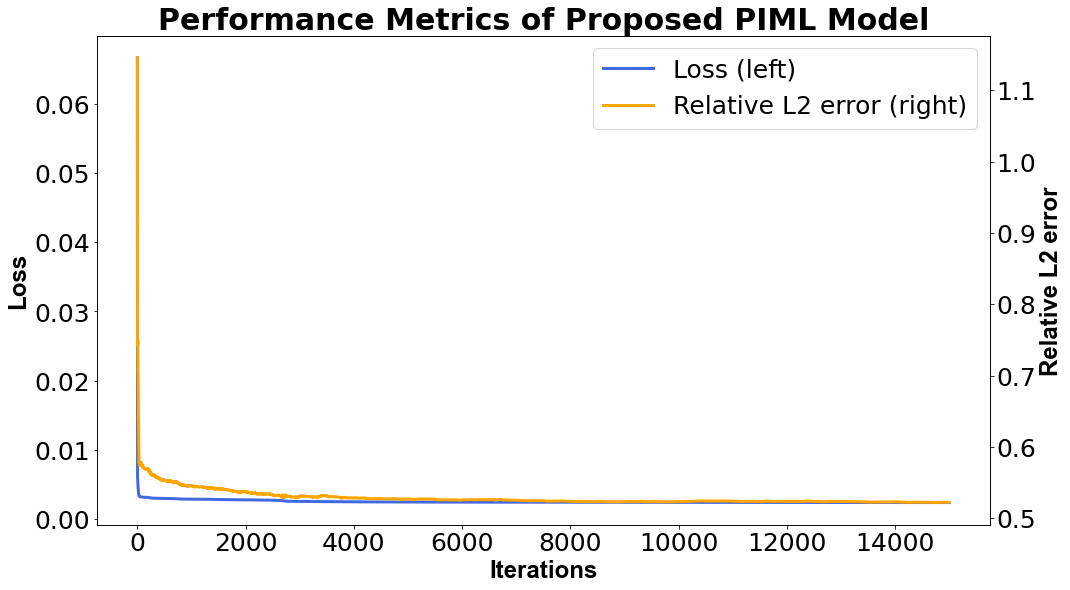

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.02164803323613614
MSE =  0.0032102094245254386
RMSE =  0.05665871004996
L2 relative error = 0.5193606343849478
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

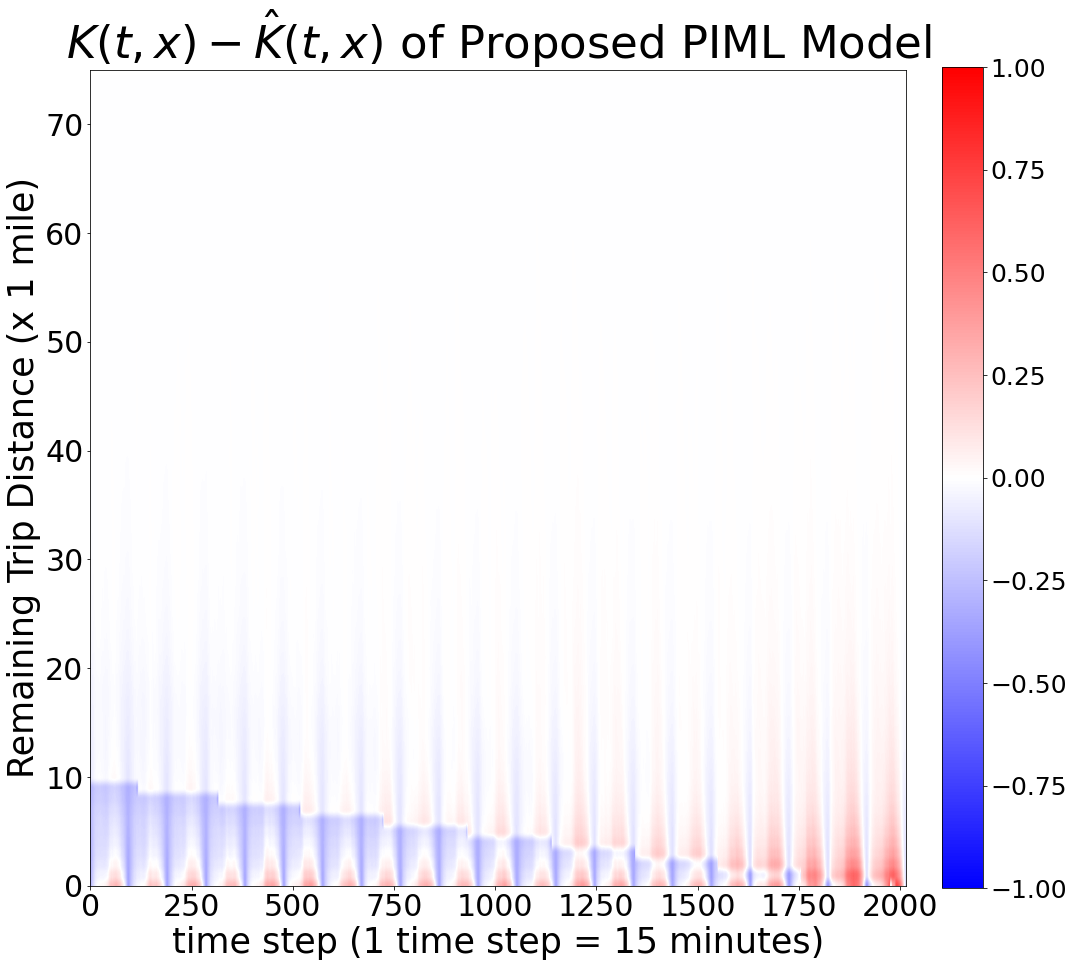

In [19]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

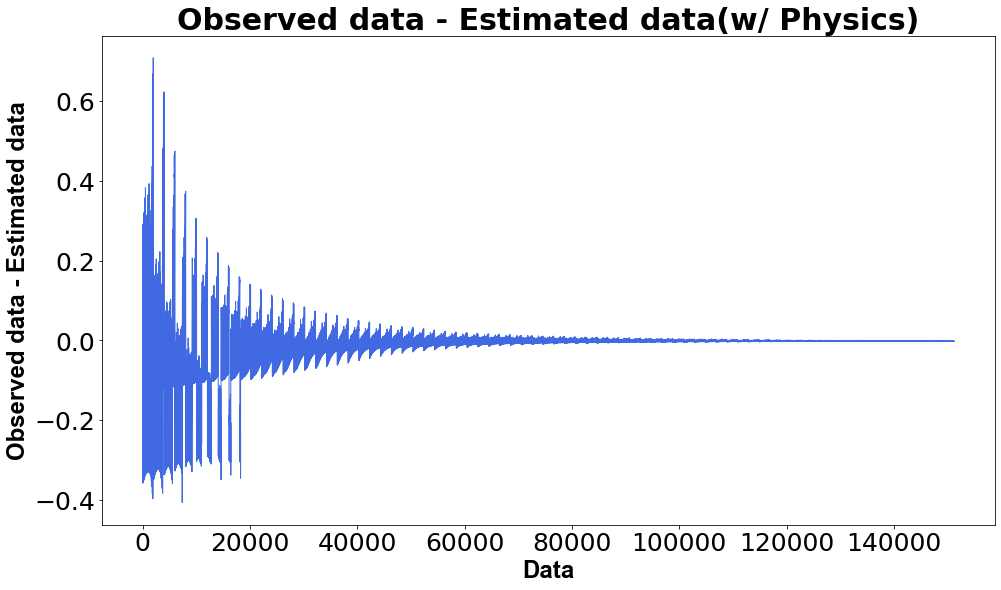

In [20]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

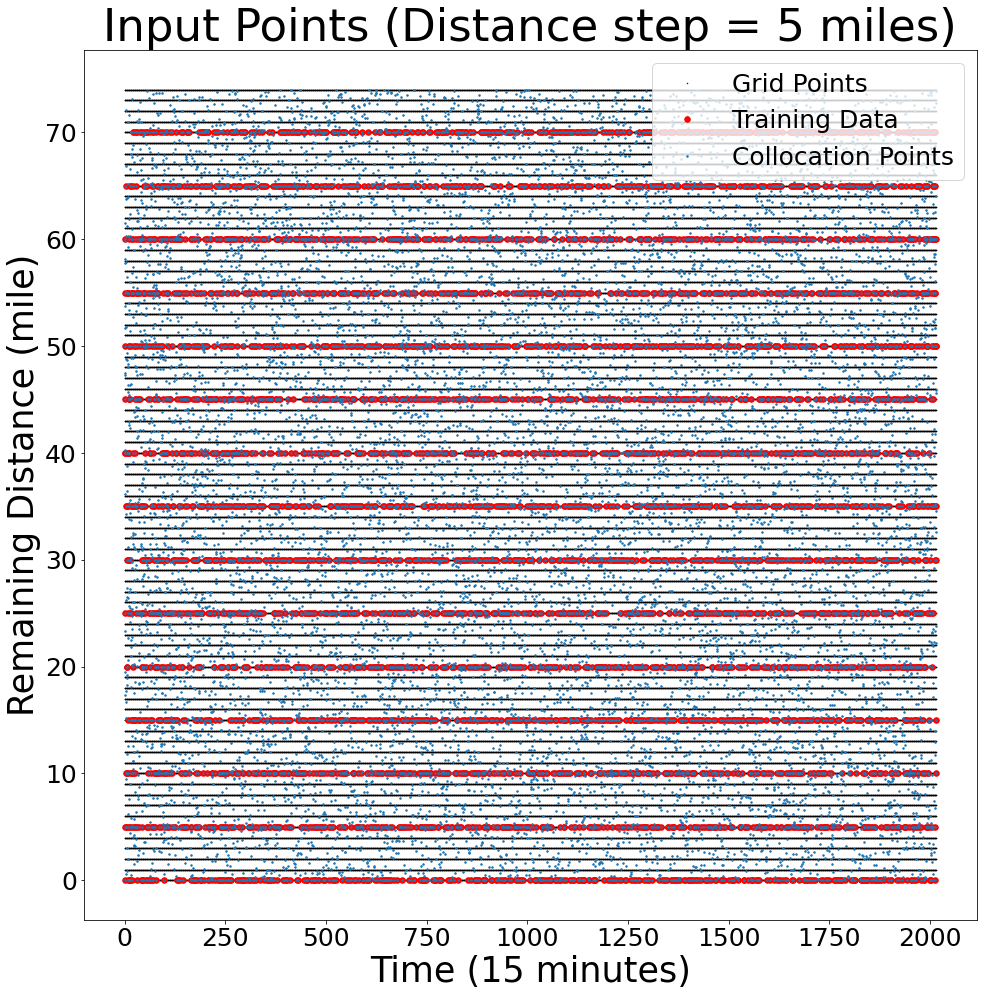

In [21]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 5 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

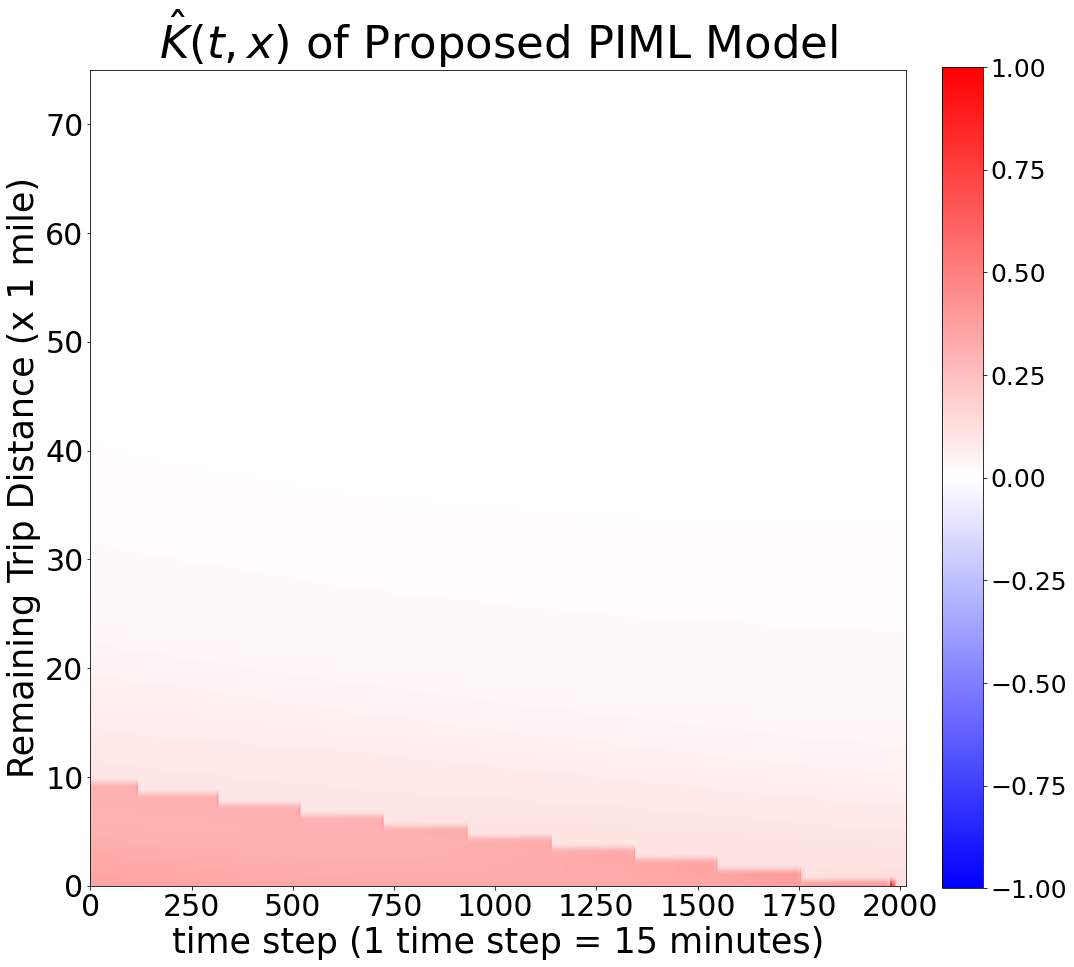

In [22]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)